In [117]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive, SeasonalWindowAverage, AutoARIMA, WindowAverage

In [118]:
def calculate_wmape(actual, forecast, weights=None):
    """
    Calculate the Weighted Mean Absolute Percentage Error (WMAPE) between two series.

    Parameters:
    actual (list or array): The actual values.
    forecast (list or array): The forecasted values.
    weights (list or array, optional): Weight for each observation. Default is None (equal weights).

    Returns:
    float: The calculated WMAPE.
    """
    if len(actual) != len(forecast):
        raise ValueError("Both series must have the same length.")

    if weights is None:
        weights = [1] * len(actual)

    if len(weights) != len(actual):
        raise ValueError("Number of weights must match the length of the series.")

    total_weighted_absolute_percentage_error = 0
    total_weights = sum(weights)

    for i in range(len(actual)):
        abs_percentage_error = abs((actual[i] - forecast[i]) / actual[i]) * 100
        weighted_abs_percentage_error = abs_percentage_error * weights[i]
        total_weighted_absolute_percentage_error += weighted_abs_percentage_error

    wmape_score = total_weighted_absolute_percentage_error / total_weights
    return wmape_score

def calculate_mape(actual, forecast):
    """
    Calculate the Mean Absolute Percentage Error (MAPE) between two series.

    Parameters:
    actual (list or array): The actual values.
    forecast (list or array): The forecasted values.

    Returns:
    float: The calculated MAPE.
    """
    if len(actual) != len(forecast):
        raise ValueError("Both series must have the same length.")

    total_absolute_percentage_error = 0

    for i in range(len(actual)):
        abs_percentage_error = abs((actual[i] - forecast[i]) / actual[i]) * 100
        total_absolute_percentage_error += abs_percentage_error

    mape_score = total_absolute_percentage_error / len(actual)
    return mape_score

def calc_wmape(y_true, y_pred):
    return np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()

def calc_mae (y_true, y_pred):
    return np.abs(y_true - y_pred).sum() / len(y_true)

In [119]:
df_path = r'C:\Users\Lucas\Desktop\FIAP\Fase 2\TechChallenge_2\data\Ibovespa_2010-2025.csv'

df = pd.read_csv(df_path)

df

Data   Último  Abertura   Máxima   Mínima   Vol.    Var%
0     04.01.2010   70.045    68.587   70.081   68.587  1,66M   2,12%
1     05.01.2010   70.240    70.046   70.595   69.928  1,98M   0,28%
2     06.01.2010   70.729    70.236   70.937   70.016  2,24M   0,70%
3     07.01.2010   70.451    70.723   70.723   70.045  1,55M  -0,39%
4     08.01.2010   70.263    70.455   70.766   70.158  1,63M  -0,27%
...          ...      ...       ...      ...      ...    ...     ...
3835  25.06.2025  135.767   137.163  137.163  135.565  7,71B  -1,02%
3836  26.06.2025  137.114   135.767  137.353  135.756  8,02B   0,99%
3837  27.06.2025  136.866   137.113  137.209  136.469  6,24B  -0,18%
3838  30.06.2025  138.855   136.865  139.103  136.430  7,68B   1,45%
3839  01.07.2025  139.549   138.855  139.695  138.855  6,35B   0,50%

[3840 rows x 7 columns]

In [120]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840 entries, 0 to 3839
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      3840 non-null   object 
 1   Último    3840 non-null   float64
 2   Abertura  3840 non-null   float64
 3   Máxima    3840 non-null   float64
 4   Mínima    3840 non-null   float64
 5   Vol.      3839 non-null   object 
 6   Var%      3840 non-null   object 
dtypes: float64(4), object(3)
memory usage: 210.1+ KB
None


In [121]:
print(df.isna().sum())

Data        0
Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        1
Var%        0
dtype: int64


In [122]:
# Coluna Data com tipo datetime
df = pd.read_csv(df_path, parse_dates=[0], dayfirst=True)

df.tail()

Data   Último  Abertura   Máxima   Mínima   Vol.    Var%
3835 2025-06-25  135.767   137.163  137.163  135.565  7,71B  -1,02%
3836 2025-06-26  137.114   135.767  137.353  135.756  8,02B   0,99%
3837 2025-06-27  136.866   137.113  137.209  136.469  6,24B  -0,18%
3838 2025-06-30  138.855   136.865  139.103  136.430  7,68B   1,45%
3839 2025-07-01  139.549   138.855  139.695  138.855  6,35B   0,50%

In [123]:
# Filtra o DataFrame para mostrar apenas as linhas que contêm QUALQUER valor nulo
linhas_com_nulos = df[df.isnull().any(axis=1)]

print(linhas_com_nulos)

           Data  Último  Abertura  Máxima  Mínima Vol.    Var%
1508 2016-02-10  40.377    40.592  40.592   39.96  NaN  -0,53%


In [124]:
df = df.dropna()

In [125]:
df.columns = ['ds', 'y', 'abertura', 'max', 'min', 'volume', 'variacao']

df.head()

ds       y  abertura     max     min volume variacao
0 2010-01-04  70.045    68.587  70.081  68.587  1,66M    2,12%
1 2010-01-05  70.240    70.046  70.595  69.928  1,98M    0,28%
2 2010-01-06  70.729    70.236  70.937  70.016  2,24M    0,70%
3 2010-01-07  70.451    70.723  70.723  70.045  1,55M   -0,39%
4 2010-01-08  70.263    70.455  70.766  70.158  1,63M   -0,27%

In [126]:
# Aplicação das correções dos dados
df["ds"] = pd.to_datetime(df["ds"], format="%d.%m.%Y")
df = df.sort_values("ds")

In [127]:
df.tail()

ds        y  abertura      max      min volume variacao
3835 2025-06-25  135.767   137.163  137.163  135.565  7,71B   -1,02%
3836 2025-06-26  137.114   135.767  137.353  135.756  8,02B    0,99%
3837 2025-06-27  136.866   137.113  137.209  136.469  6,24B   -0,18%
3838 2025-06-30  138.855   136.865  139.103  136.430  7,68B    1,45%
3839 2025-07-01  139.549   138.855  139.695  138.855  6,35B    0,50%

In [128]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 3839 entries, 0 to 3839
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   ds        3839 non-null   datetime64[ns]
 1   y         3839 non-null   float64       
 2   abertura  3839 non-null   float64       
 3   max       3839 non-null   float64       
 4   min       3839 non-null   float64       
 5   volume    3839 non-null   object        
 6   variacao  3839 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 239.9+ KB
None


In [129]:
# Função para padronizar os dados
def corrige_volumetria(valor:str):
    if isinstance(valor, str):
        valor = valor.replace(".", "").replace(",", ".")
        if "K" in valor:
            return float(valor.replace("K", "")) /100
        elif "M" in valor:
            return float(valor.replace("M", "")) 
        elif "B" in valor:
            return float(valor.replace("B", "")) 
        elif "%" in valor:
            return float(valor.replace("%", ""))
    return float(valor)

In [130]:
df.columns

Index(['ds', 'y', 'abertura', 'max', 'min', 'volume', 'variacao'], dtype='object')

In [131]:
# Aplicação das correções dos dados
df["ds"] = pd.to_datetime(df["ds"], format="%d.%m.%Y")
df["volume"] = df["volume"].apply(corrige_volumetria)
df["variacao"] = df["variacao"].apply(corrige_volumetria)

## Análise Exploratória

## Variação

In [132]:
print(f'Variação máxima (%): {df.variacao.max()}')
print(df.loc[df.variacao == df.variacao.max()]['ds'])

print('\n')

print(f'Variação mínima (%): {df.variacao.min()}')
print(df.loc[df.variacao == df.variacao.min()]['ds'])

Variação máxima (%): 13.91
2521   2020-03-13
Name: ds, dtype: datetime64[ns]


Variação mínima (%): -14.78
2520   2020-03-12
Name: ds, dtype: datetime64[ns]


Os picos de variação máxima e mínima do índica IBOVESPA ocorreram em períodos bem próximos na linha do tempo.

Tanto o máximo de desvalorização  como o de valorização da bolsa ocorreram no ano de 2020, provavelmente efeito da pandemia. É um alerta de como esse ano foi atípico, tais dados podem não ser bons conjuntos de treino e teste

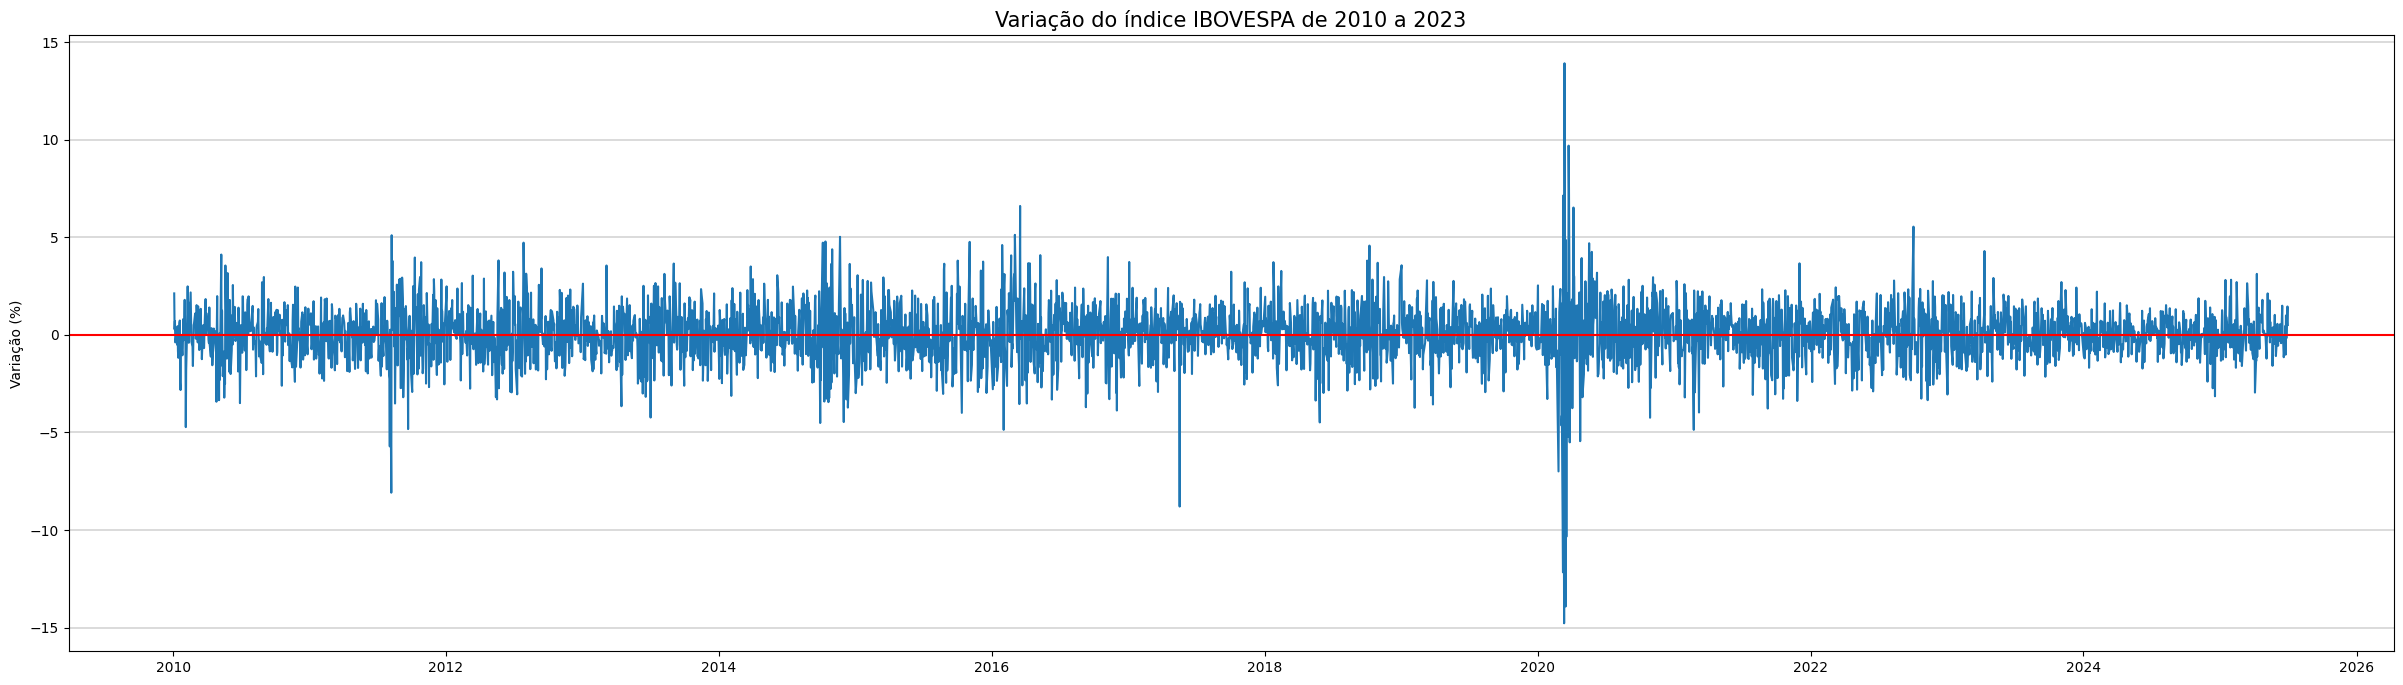

In [133]:
fig, ax = plt.subplots(figsize=(30,8))

sns.lineplot(df, x='ds', y='variacao', ax=ax)
ax.axhline(y=0, color='red')

ax.grid(True, color='black', linewidth=0.2, axis='y')

ax.set_title('Variação do índice IBOVESPA de 2010 a 2023', fontsize=15)
ax.set_xlabel('')
ax.set_ylabel('Variação (%)')

plt.show()

Percebe-se um gráfico com muitos altos e baixos, porém com a maioria dos valores entre -5% e +5% de variação. 

Ocorrem alguns pontos no gráfico em que a variação ultrapassa esses valores, com destaque novamente para o ano de 2020 que apresentou o comportamento mais incostante na série.

## Volume

Total de valores negociados no dia, em milhões R$

In [134]:
print(f'Volume máximo (milhões R$): {df.volume.max()}')
print(df.loc[df.volume == df.volume.max()]['ds'])

print('\n')

print(f'Volume mínimo (milhões R$): {df.volume.min()}')
print(df.loc[df.volume == df.volume.min()]['ds'])

Volume máximo (milhões R$): 26.03
3183   2022-11-10
Name: ds, dtype: datetime64[ns]


Volume mínimo (milhões R$): 1.0
371   2011-07-04
Name: ds, dtype: datetime64[ns]


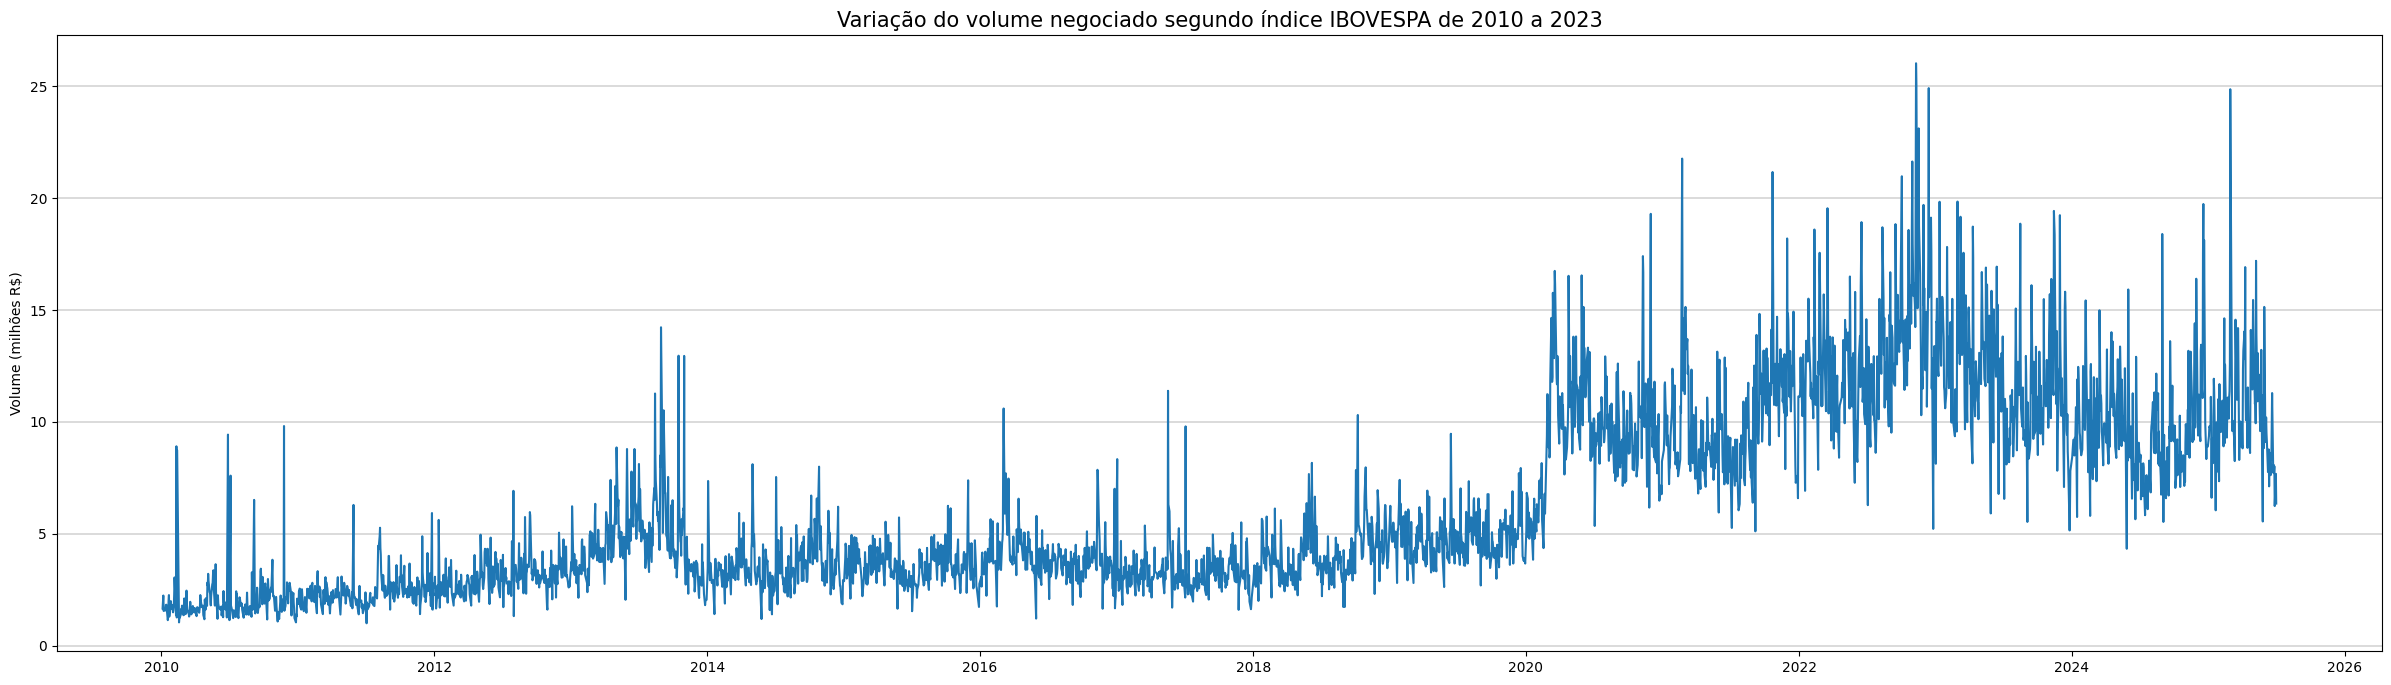

In [135]:
fig, ax = plt.subplots(figsize=(30,8))

sns.lineplot(df, x='ds', y='volume', ax=ax)

ax.grid(True, color='black', linewidth=0.2, axis='y')

ax.set_title('Variação do volume negociado segundo índice IBOVESPA de 2010 a 2023', fontsize=15)
ax.set_xlabel('')
ax.set_ylabel('Volume (milhões R$)')

plt.show()

Agora, o gráfico ilustra bem a evolução do mercado variável no Brasil. É visível que, até meados de 2019, o volume de negociações sofreu pouca alteração com uma leve tendência de crescimento.

Com a redução nas taxas de juros e Selic, e consequentemente a baixa nos investimentos de Renda Fixa, o mercado de Renda Variável teve um "boom" a partir do ano de 2020.

https://www.cnnbrasil.com.br/economia/numero-de-investidores-na-bolsa-cresce-15-em-2022-apostando-na-diversificacao/

## Diferença entre índice mínimo e máximo diário

Com a diferença entre as variáveis "min" e "max" é possível identificar dias em que o índice IBOVESPA sofreu maior alteração durante as próprias negociações do dia. 

Desta forma, pode-se verificar dias atípicos, possivelmente causados por fatores e eventos político-econômicos importantes, que resultaram na flutuação do índice durante o período de um dia.

In [136]:
df['dif_min_max'] = df['max'] - df['min']
df

ds        y  abertura      max      min  volume  variacao  \
0    2010-01-04   70.045    68.587   70.081   68.587    1.66      2.12   
1    2010-01-05   70.240    70.046   70.595   69.928    1.98      0.28   
2    2010-01-06   70.729    70.236   70.937   70.016    2.24      0.70   
3    2010-01-07   70.451    70.723   70.723   70.045    1.55     -0.39   
4    2010-01-08   70.263    70.455   70.766   70.158    1.63     -0.27   
...         ...      ...       ...      ...      ...     ...       ...   
3835 2025-06-25  135.767   137.163  137.163  135.565    7.71     -1.02   
3836 2025-06-26  137.114   135.767  137.353  135.756    8.02      0.99   
3837 2025-06-27  136.866   137.113  137.209  136.469    6.24     -0.18   
3838 2025-06-30  138.855   136.865  139.103  136.430    7.68      1.45   
3839 2025-07-01  139.549   138.855  139.695  138.855    6.35      0.50   

      dif_min_max  
0           1.494  
1           0.667  
2           0.921  
3           0.678  
4           0.608  
...           ...  
3835        1.598  
3836        1.597  
3837        0.740  
3838        2.673  
3839        0.840  

[3839 rows x 8 columns]

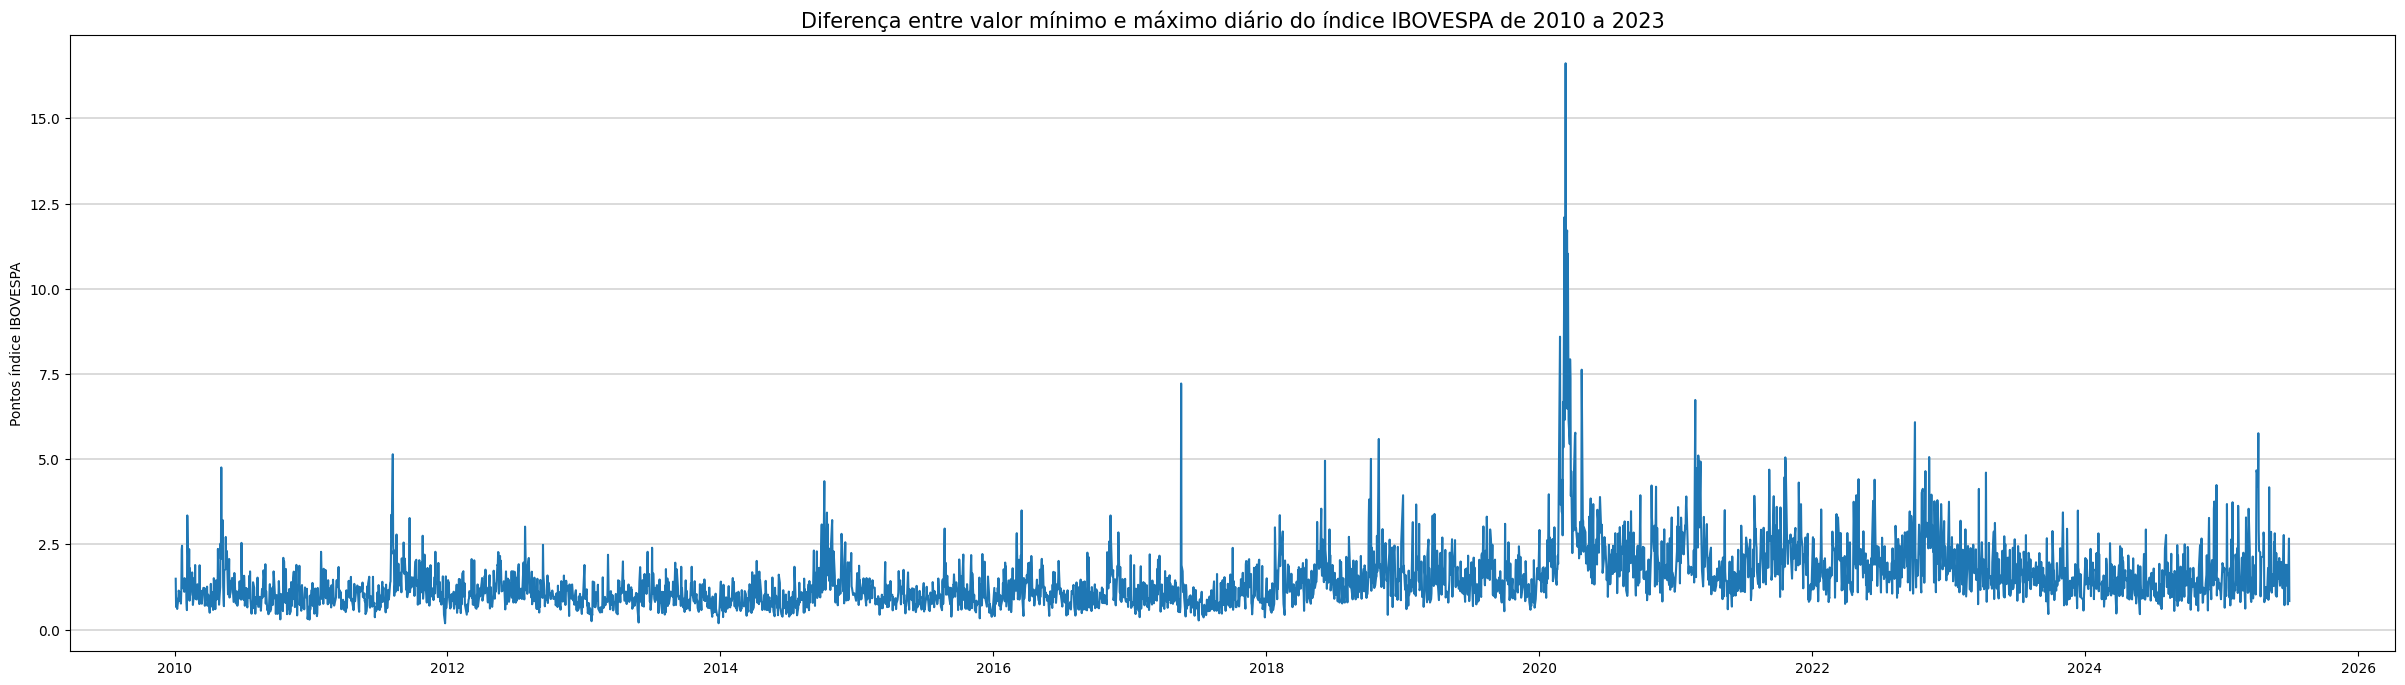

In [137]:
fig, ax = plt.subplots(figsize=(30,8))

sns.lineplot(df, x='ds', y='dif_min_max', ax=ax)

ax.grid(True, color='black', linewidth=0.2, axis='y')

ax.set_title('Diferença entre valor mínimo e máximo diário do índice IBOVESPA de 2010 a 2023', fontsize=15)
ax.set_xlabel('')
ax.set_ylabel('Pontos índice IBOVESPA')

plt.show()

In [138]:
print('Número de dias com diferença entre mínimo e máximo maior que 5%:')
df.loc[df.dif_min_max > 5].ds.dt.year.value_counts()

Número de dias com diferença entre mínimo e máximo maior que 5%:


ds
2020    19
2021     3
2018     2
2022     2
2011     1
2017     1
2025     1
Name: count, dtype: int64

Este resultado reforça mais uma vez o comportamento atípico do IBOVESPA a partir de 2020. Possivelmente, 2021 e 2022 aparecem em seguida no rankin também por reflexo dos efeitos da crise causada pela pandemia.

## Fechamento

In [139]:
print(f'Índice máximo no fechamento: {df.y.max()}')
print(df.loc[df.y == df.y.max()]['ds'])

print('\n')

print(f'Índice máximo no fechamento: {df.y.min()}')
print(df.loc[df.y == df.y.min()]['ds'])

Índice máximo no fechamento: 140.11
3810   2025-05-20
Name: ds, dtype: datetime64[ns]


Índice máximo no fechamento: 37.497
1499   2016-01-26
Name: ds, dtype: datetime64[ns]


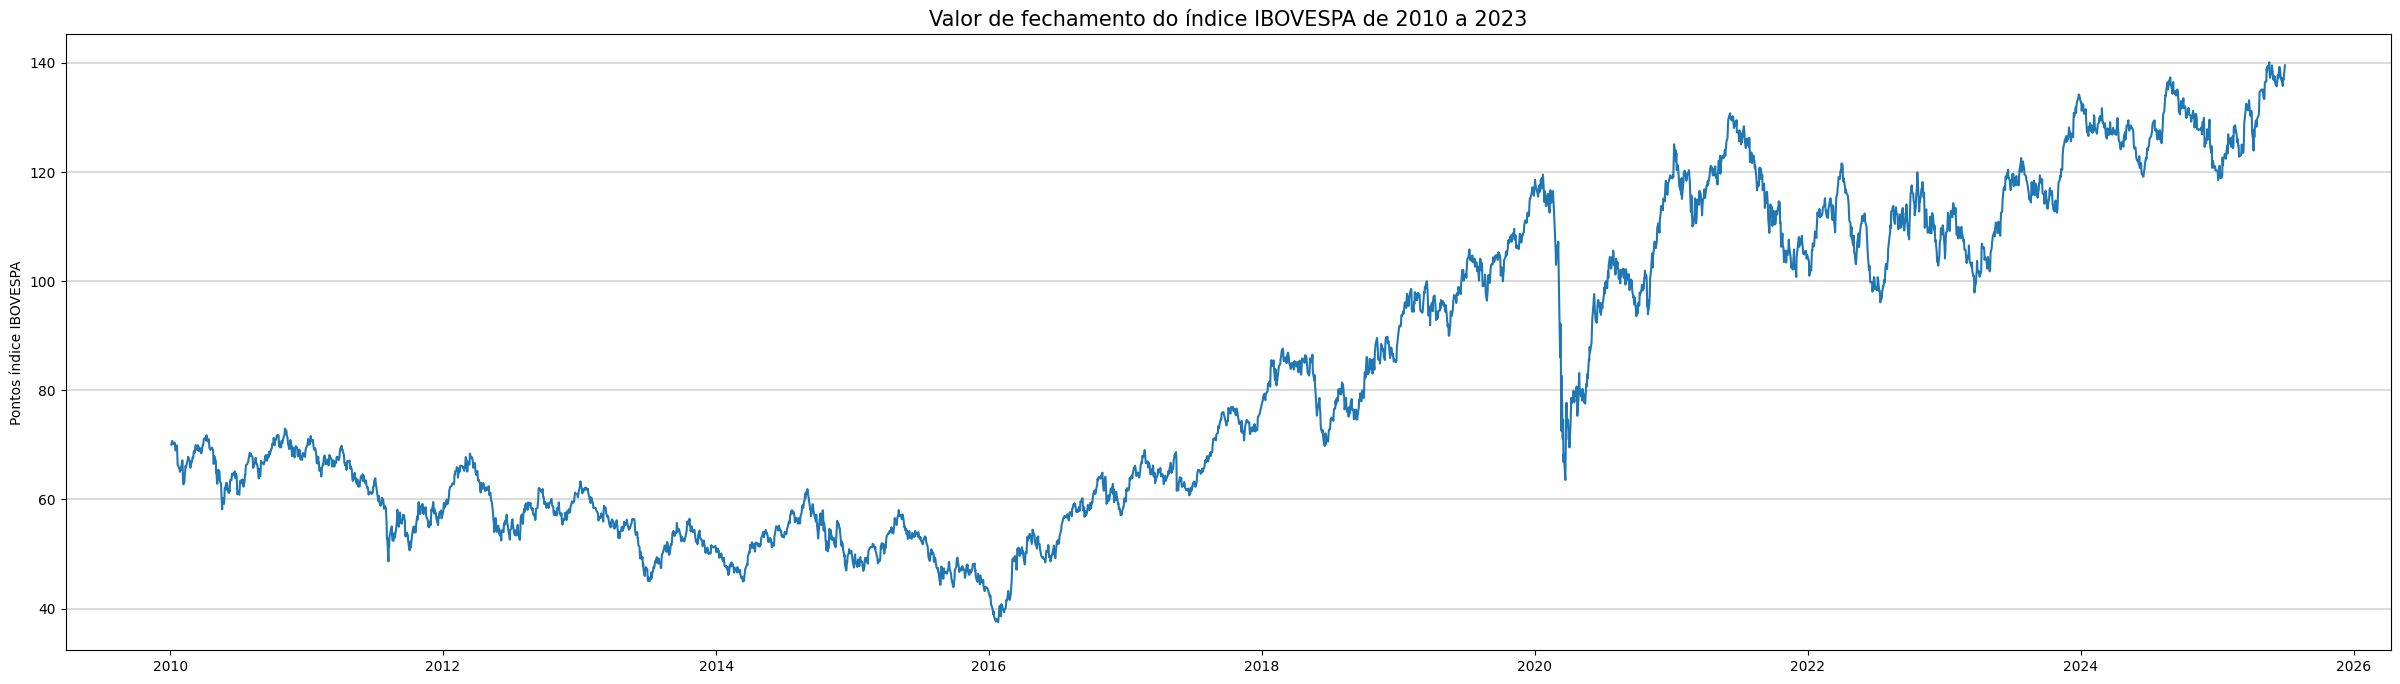

In [140]:
fig, ax = plt.subplots(figsize=(30,8))

sns.lineplot(df, x='ds', y='y', ax=ax)

ax.grid(True, color='black', linewidth=0.2, axis='y')

ax.set_title('Valor de fechamento do índice IBOVESPA de 2010 a 2023', fontsize=15)
ax.set_xlabel('')
ax.set_ylabel('Pontos índice IBOVESPA')

plt.show()

Analisando a série temporal do valor de fechamento diário do IBOVESPA, de maneira geral ficam evidentes quatro momentos distintos:

1. Tendência de queda de 2010 a 2016
2. Alta tendência de subida entre 2016 e 2020
3. Queda abrupta com a pandemia em 2020
4. Retomada da normalidade a partir do final de 2021, com série variando em momentos de queda e alta

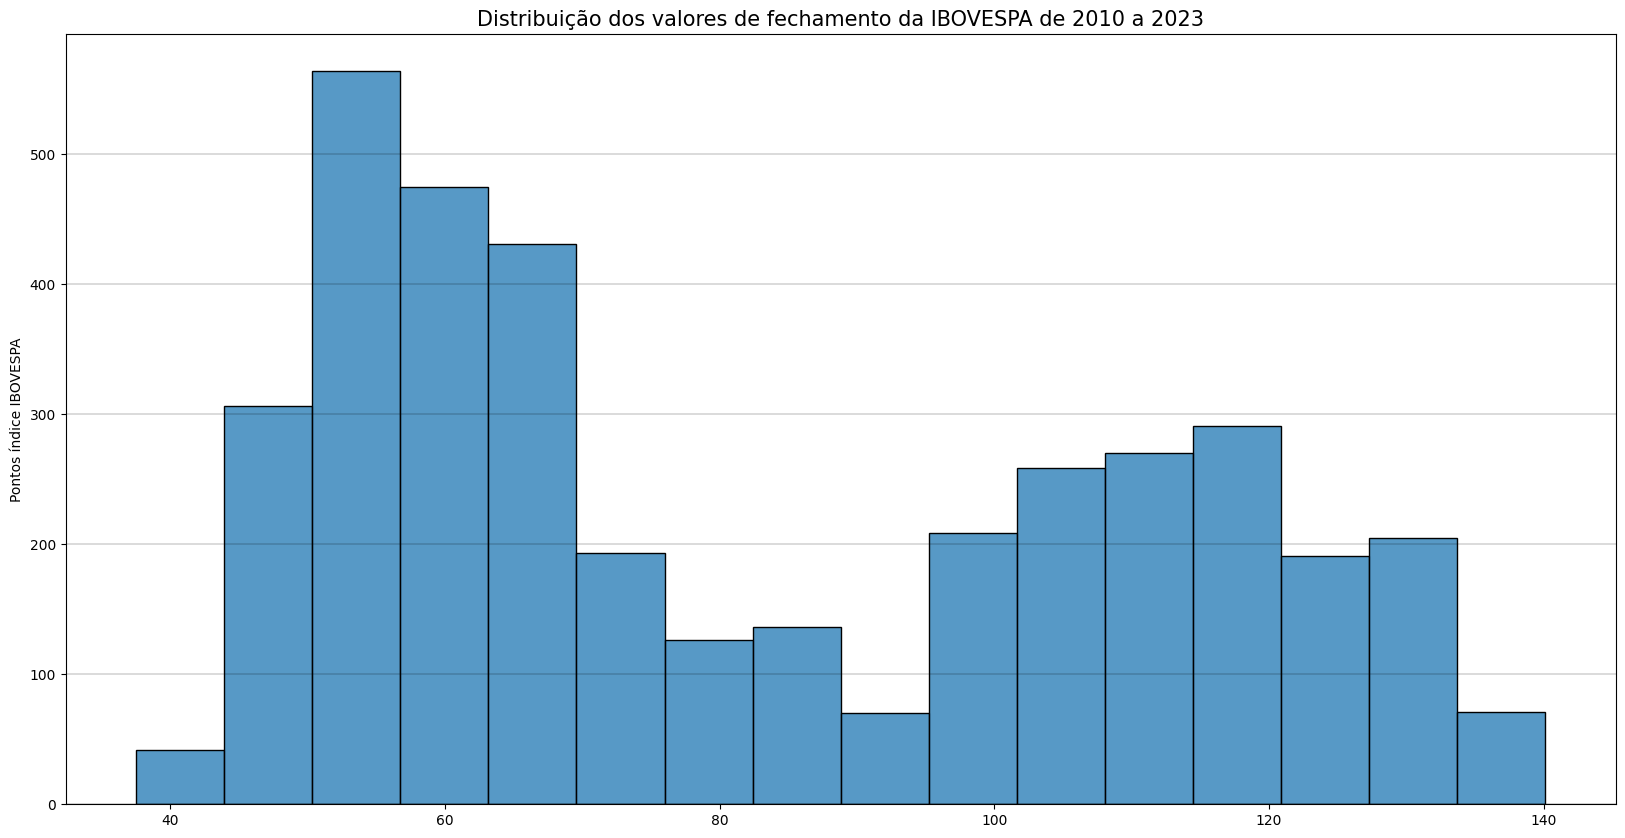

In [141]:
fig, ax = plt.subplots(figsize=(20,10))

sns.histplot(df, x='y', ax=ax)

ax.grid(True, color='black', linewidth=0.2, axis='y')

ax.set_title('Distribuição dos valores de fechamento da IBOVESPA de 2010 a 2023', fontsize=15)
ax.set_xlabel('')
ax.set_ylabel('Pontos índice IBOVESPA')

plt.show()

A série temporal se divide em basicamente dois grupos de acordo com o valor de fechamento. Primeiramente, o maior grupo que representa dias com valor de fechamento entre 50 e 80 pontos, relacionado principalmente aos de 2010 a 2016.

Já o segundo grande grupo concentra dias com valor de fechamento superior aos 100 pontos. Este grupo está relacionado principalmente ao período posterior ao ano de 2019.

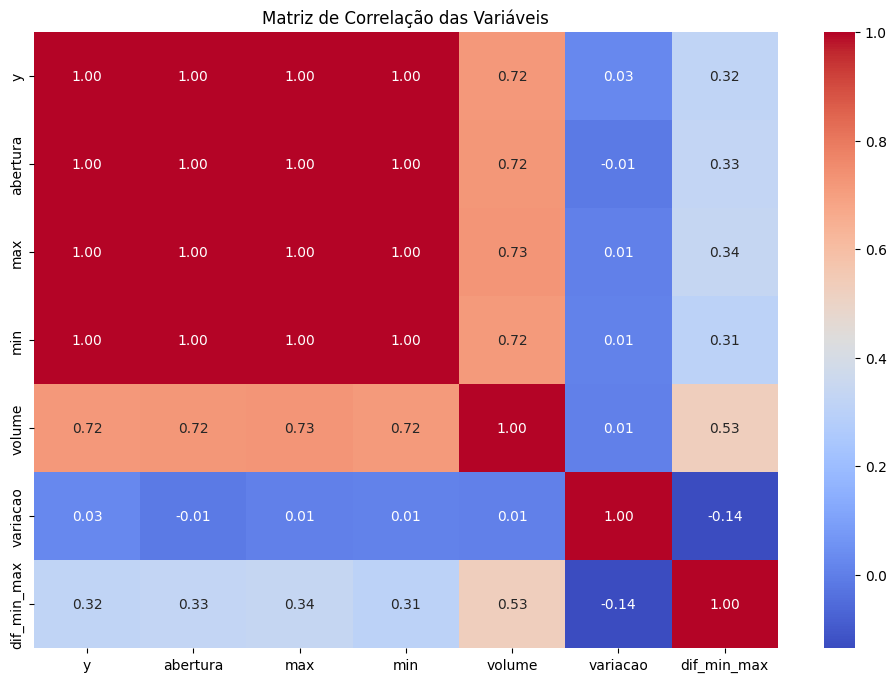

In [142]:
# Heatmap para veificar multicolinearidade
plt.figure(figsize=(12, 8))
sns.heatmap(df.drop(columns=["ds"]).corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlação das Variáveis")
plt.show()

# Série temporal original

## Componentes da série

In [143]:
from statsmodels.tsa.seasonal import seasonal_decompose

Para ser possível visualizar as componentes da série, é necessário preencher as lacunas na série temporal causada por fins de semana e feriados.

Será utilizado o método ffill, que preenche valores NaN com o último valor válido da coluna.

In [144]:
df.tail(14)

ds        y  abertura      max      min  volume  variacao  \
3826 2025-06-11  137.128   136.443  137.531  135.628    8.77      0.51   
3827 2025-06-12  137.800   137.127  137.931  136.175    7.12      0.49   
3828 2025-06-13  137.213   137.800  137.800  136.586    8.63     -0.43   
3829 2025-06-16  139.256   137.212  139.988  137.212    7.62      1.49   
3830 2025-06-17  138.840   139.256  139.497  138.293    8.38     -0.30   
3831 2025-06-18  138.717   138.844  139.161  138.443    8.32     -0.09   
3832 2025-06-20  137.116   138.715  138.719  136.815   11.29     -1.15   
3833 2025-06-23  136.551   137.116  137.130  135.835    7.73     -0.41   
3834 2025-06-24  137.165   136.552  138.156  136.254    8.08      0.45   
3835 2025-06-25  135.767   137.163  137.163  135.565    7.71     -1.02   
3836 2025-06-26  137.114   135.767  137.353  135.756    8.02      0.99   
3837 2025-06-27  136.866   137.113  137.209  136.469    6.24     -0.18   
3838 2025-06-30  138.855   136.865  139.103  136.430    7.68      1.45   
3839 2025-07-01  139.549   138.855  139.695  138.855    6.35      0.50   

      dif_min_max  
3826        1.903  
3827        1.756  
3828        1.214  
3829        2.776  
3830        1.204  
3831        0.718  
3832        1.904  
3833        1.295  
3834        1.902  
3835        1.598  
3836        1.597  
3837        0.740  
3838        2.673  
3839        0.840

In [145]:
# DataFrame com Index datetime
df_date_index = df[['ds','y']].copy()
df_date_index.index = pd.to_datetime(df_date_index.ds, format='%Y-%m-%d')
df_date_index.drop(columns=['ds'], inplace=True)
df_date_index = df_date_index.asfreq('d')
df_date_index.fillna(method='ffill', inplace=True)
display(df_date_index)

# Dataframe com coluna datetime e unique_id
df_date_col = df_date_index.reset_index()
df_date_col['unique_id'] = 'ibovespa'
display(df_date_col)

y
ds                 
2010-01-04   70.045
2010-01-05   70.240
2010-01-06   70.729
2010-01-07   70.451
2010-01-08   70.263
...             ...
2025-06-27  136.866
2025-06-28  136.866
2025-06-29  136.866
2025-06-30  138.855
2025-07-01  139.549

[5658 rows x 1 columns]

ds        y unique_id
0    2010-01-04   70.045  ibovespa
1    2010-01-05   70.240  ibovespa
2    2010-01-06   70.729  ibovespa
3    2010-01-07   70.451  ibovespa
4    2010-01-08   70.263  ibovespa
...         ...      ...       ...
5653 2025-06-27  136.866  ibovespa
5654 2025-06-28  136.866  ibovespa
5655 2025-06-29  136.866  ibovespa
5656 2025-06-30  138.855  ibovespa
5657 2025-07-01  139.549  ibovespa

[5658 rows x 3 columns]

In [146]:
result = seasonal_decompose(df_date_index)

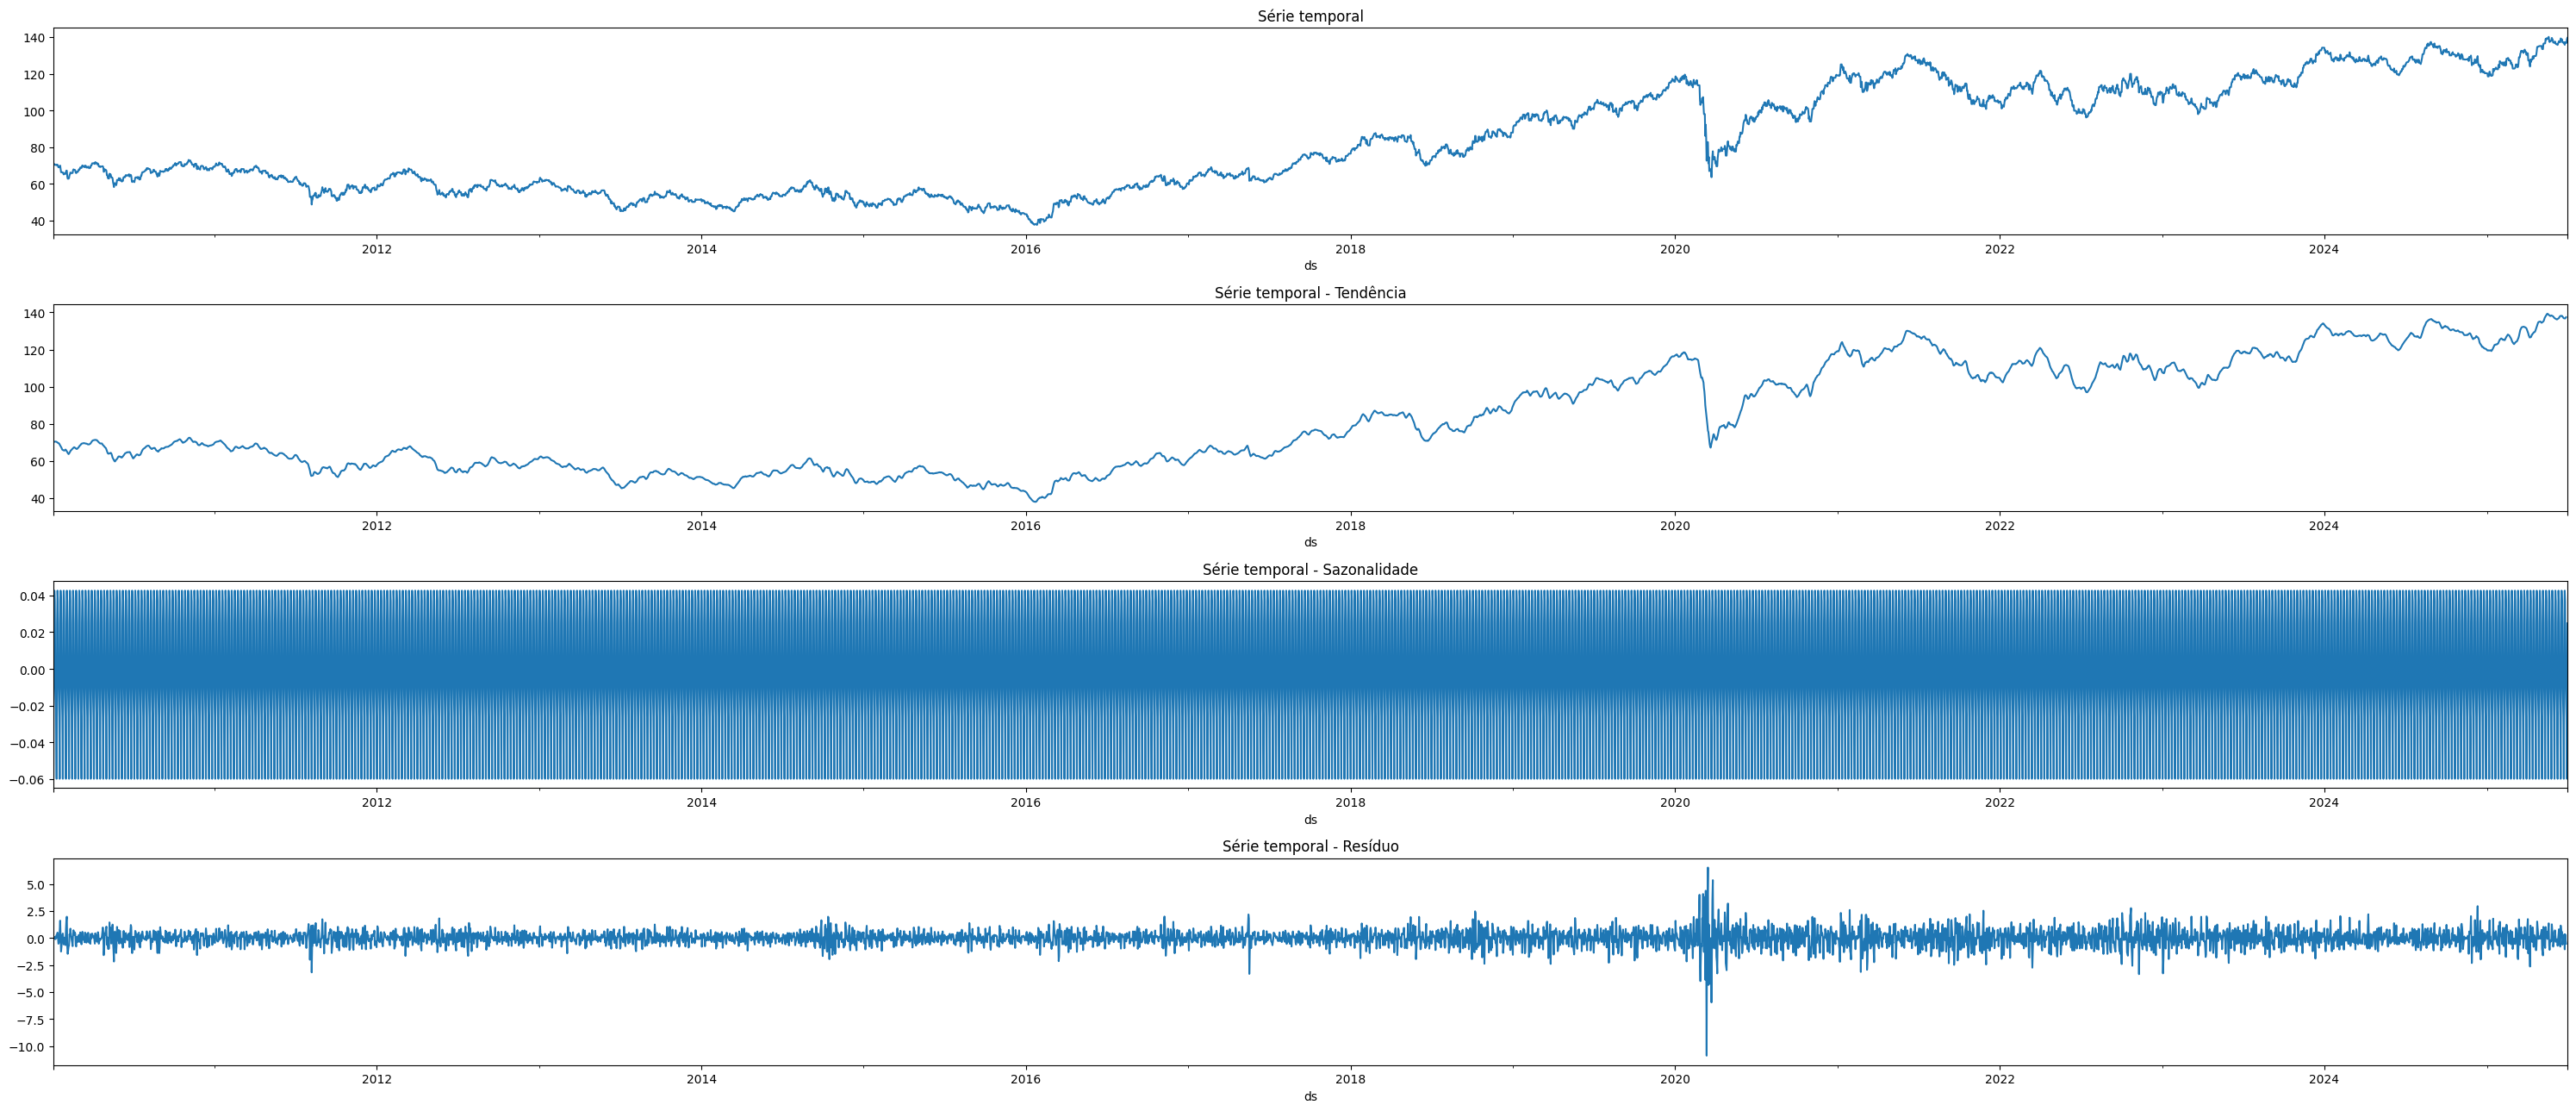

In [147]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(30, 13))

result.observed.plot(ax=ax1)
result.trend.plot(ax=ax2)
result.seasonal.plot(ax=ax3)
result.resid.plot(ax=ax4)

ax1.set_title('Série temporal')
ax2.set_title('Série temporal - Tendência')
ax3.set_title('Série temporal - Sazonalidade')
ax4.set_title('Série temporal - Resíduo')

plt.tight_layout()

Não foi possível extrair insights muito valiosos com a decomposição da série temporal em seus componentes. A tendência representa a mesma curva da própria série porém um pouco mais suavizada.

A sazonalidade têm padrão caótico, indicando que não é sazonalidade aparente nos df, o que faz bastante sentido.

Já o resíduo reforça a ideia de 2020 ser um ano fora do padrão de comportamento da curva.

## Teste ADF

- Teste A -> verificar se uma série temporal é estacionária ou não

- H0 = hipótese nula (não é estacionária)
- H1 = hipótese alternativa (é estacionária)

In [148]:
from statsmodels.tsa.stattools import adfuller

result_adfuller = adfuller(df_date_index.y)

In [149]:
print('Teste A')

print(f'Teste estatístico: {result_adfuller[0]}')
print(f'P-value: {result_adfuller[1]}')
print('\n')

print('Valores críticos:')
for key,value in result_adfuller[4].items():
    print(f'{key}: {value}')

Teste A
Teste estatístico: -0.7080337648790495
P-value: 0.8446576227818016


Valores críticos:
1%: -3.431509567118304
5%: -2.862052416111477
10%: -2.567042757510297


Não é estacionária!

## Média móvel

In [150]:
# Rolling = calcula estatísticas com base em janelas/intervalos de tempo. Neste caso, média móvel
ma = df_date_index.rolling(12).mean()

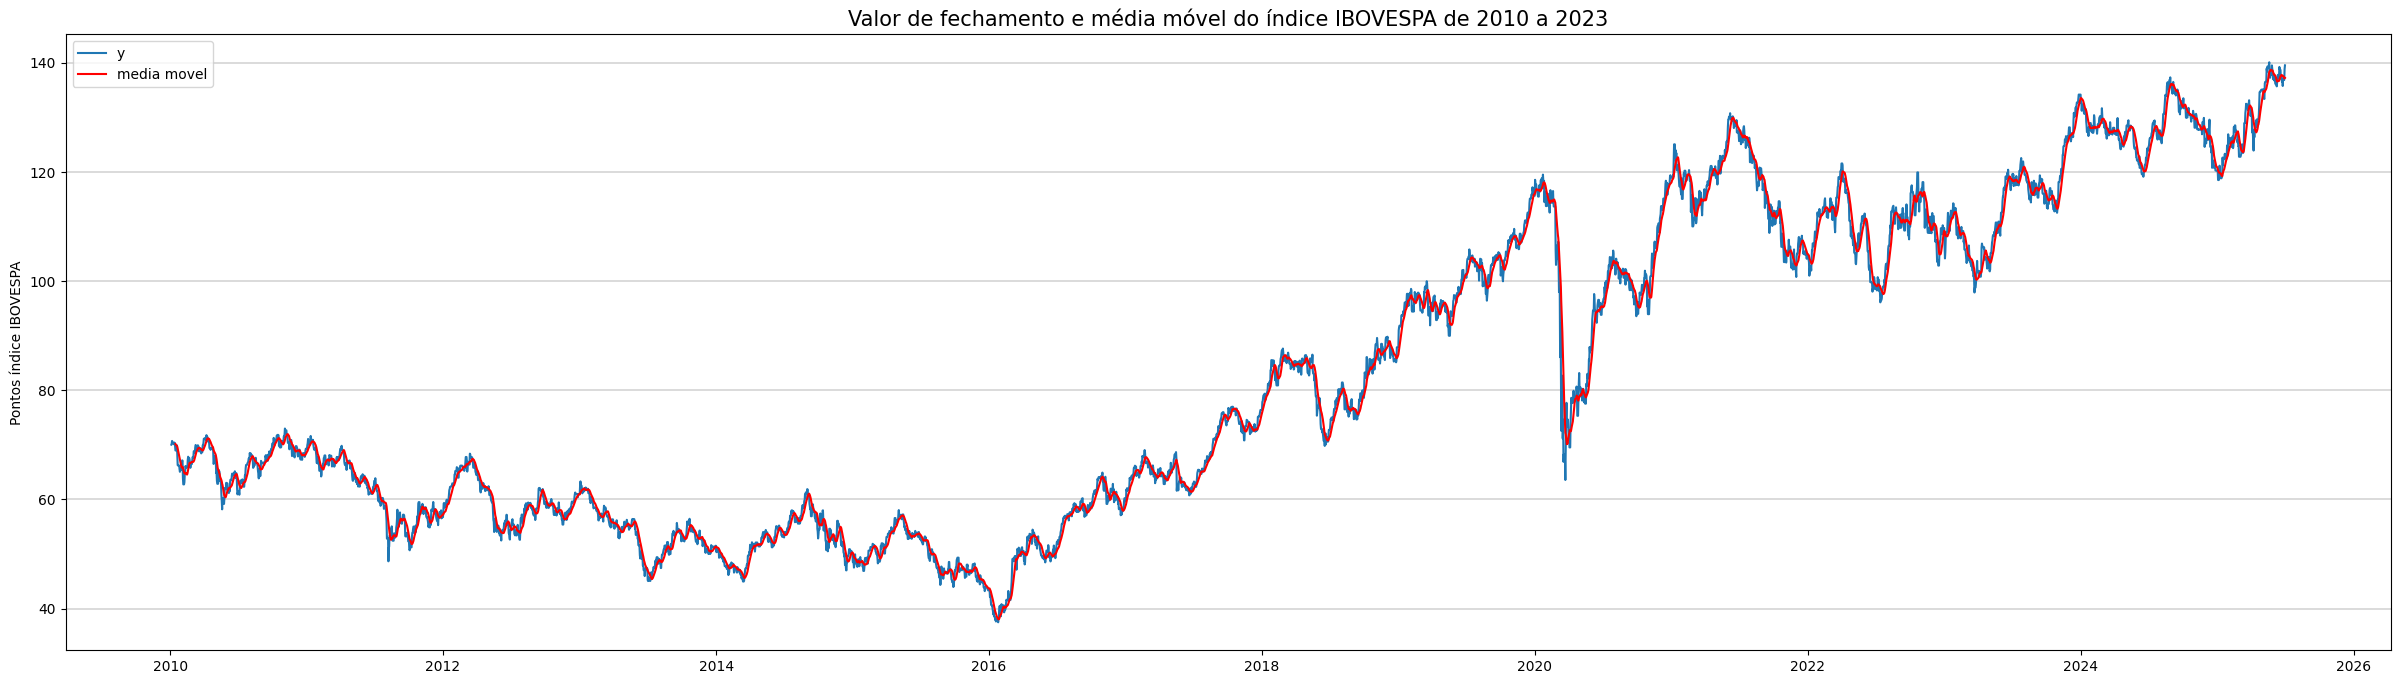

In [151]:
fig, ax = plt.subplots(figsize=(30,8))

sns.lineplot(df_date_index, x='ds', y='y', ax=ax, label='y')
sns.lineplot(ma, x='ds', y='y', ax=ax, color='r', label='media movel')

ax.grid(True, color='black', linewidth=0.2, axis='y')

ax.legend()

ax.set_title('Valor de fechamento e média móvel do índice IBOVESPA de 2010 a 2023', fontsize=15)
ax.set_xlabel('')
ax.set_ylabel('Pontos índice IBOVESPA')

plt.show()

Assim como a componente de tendência, a média móvel parece representar o mesmo comportamento da série original porém de maneira suavizada

# Série temporal com transformada logarítmica

## Média móvel

In [152]:
df_log = np.log(df_date_index)
ma_log = df_log.rolling(12).mean()

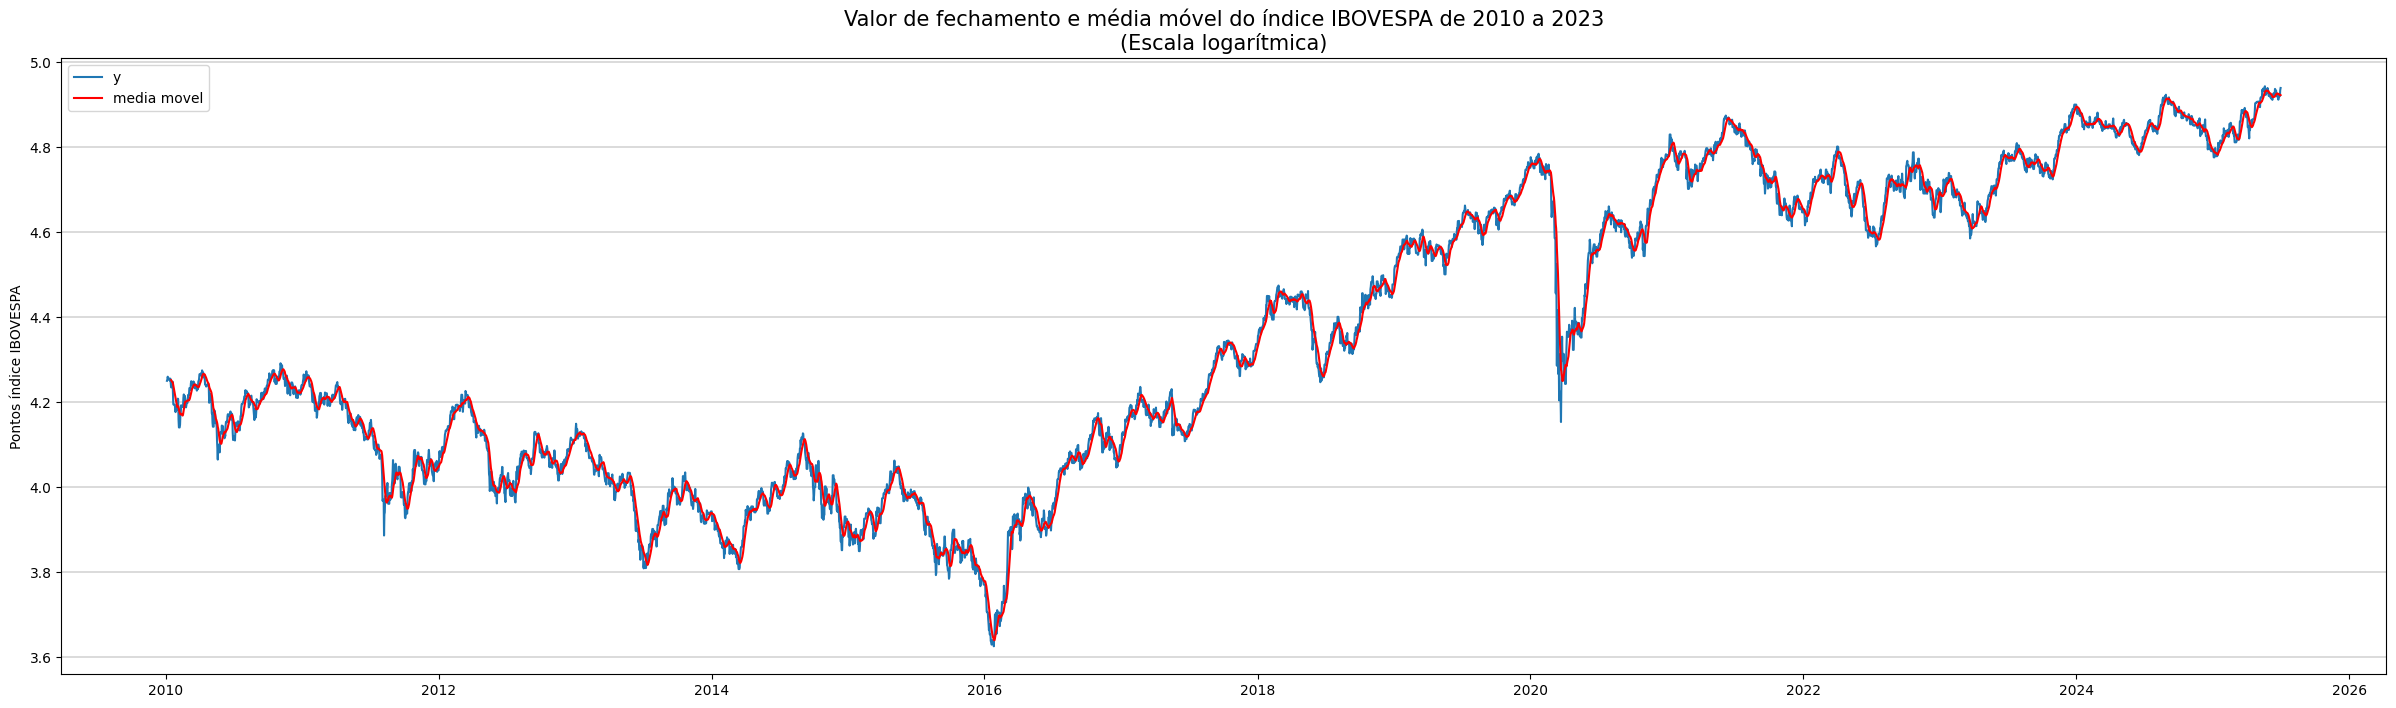

In [153]:
fig, ax = plt.subplots(figsize=(30,8))

sns.lineplot(df_log, x='ds', y='y', ax=ax, label='y')
sns.lineplot(ma_log, x='ds', y='y', ax=ax, color='r', label='media movel')

ax.grid(True, color='black', linewidth=0.2, axis='y')

ax.legend()

ax.set_title('Valor de fechamento e média móvel do índice IBOVESPA de 2010 a 2023\n(Escala logarítmica)', fontsize=15)
ax.set_xlabel('')
ax.set_ylabel('Pontos índice IBOVESPA')

plt.show()

## Componentes da série

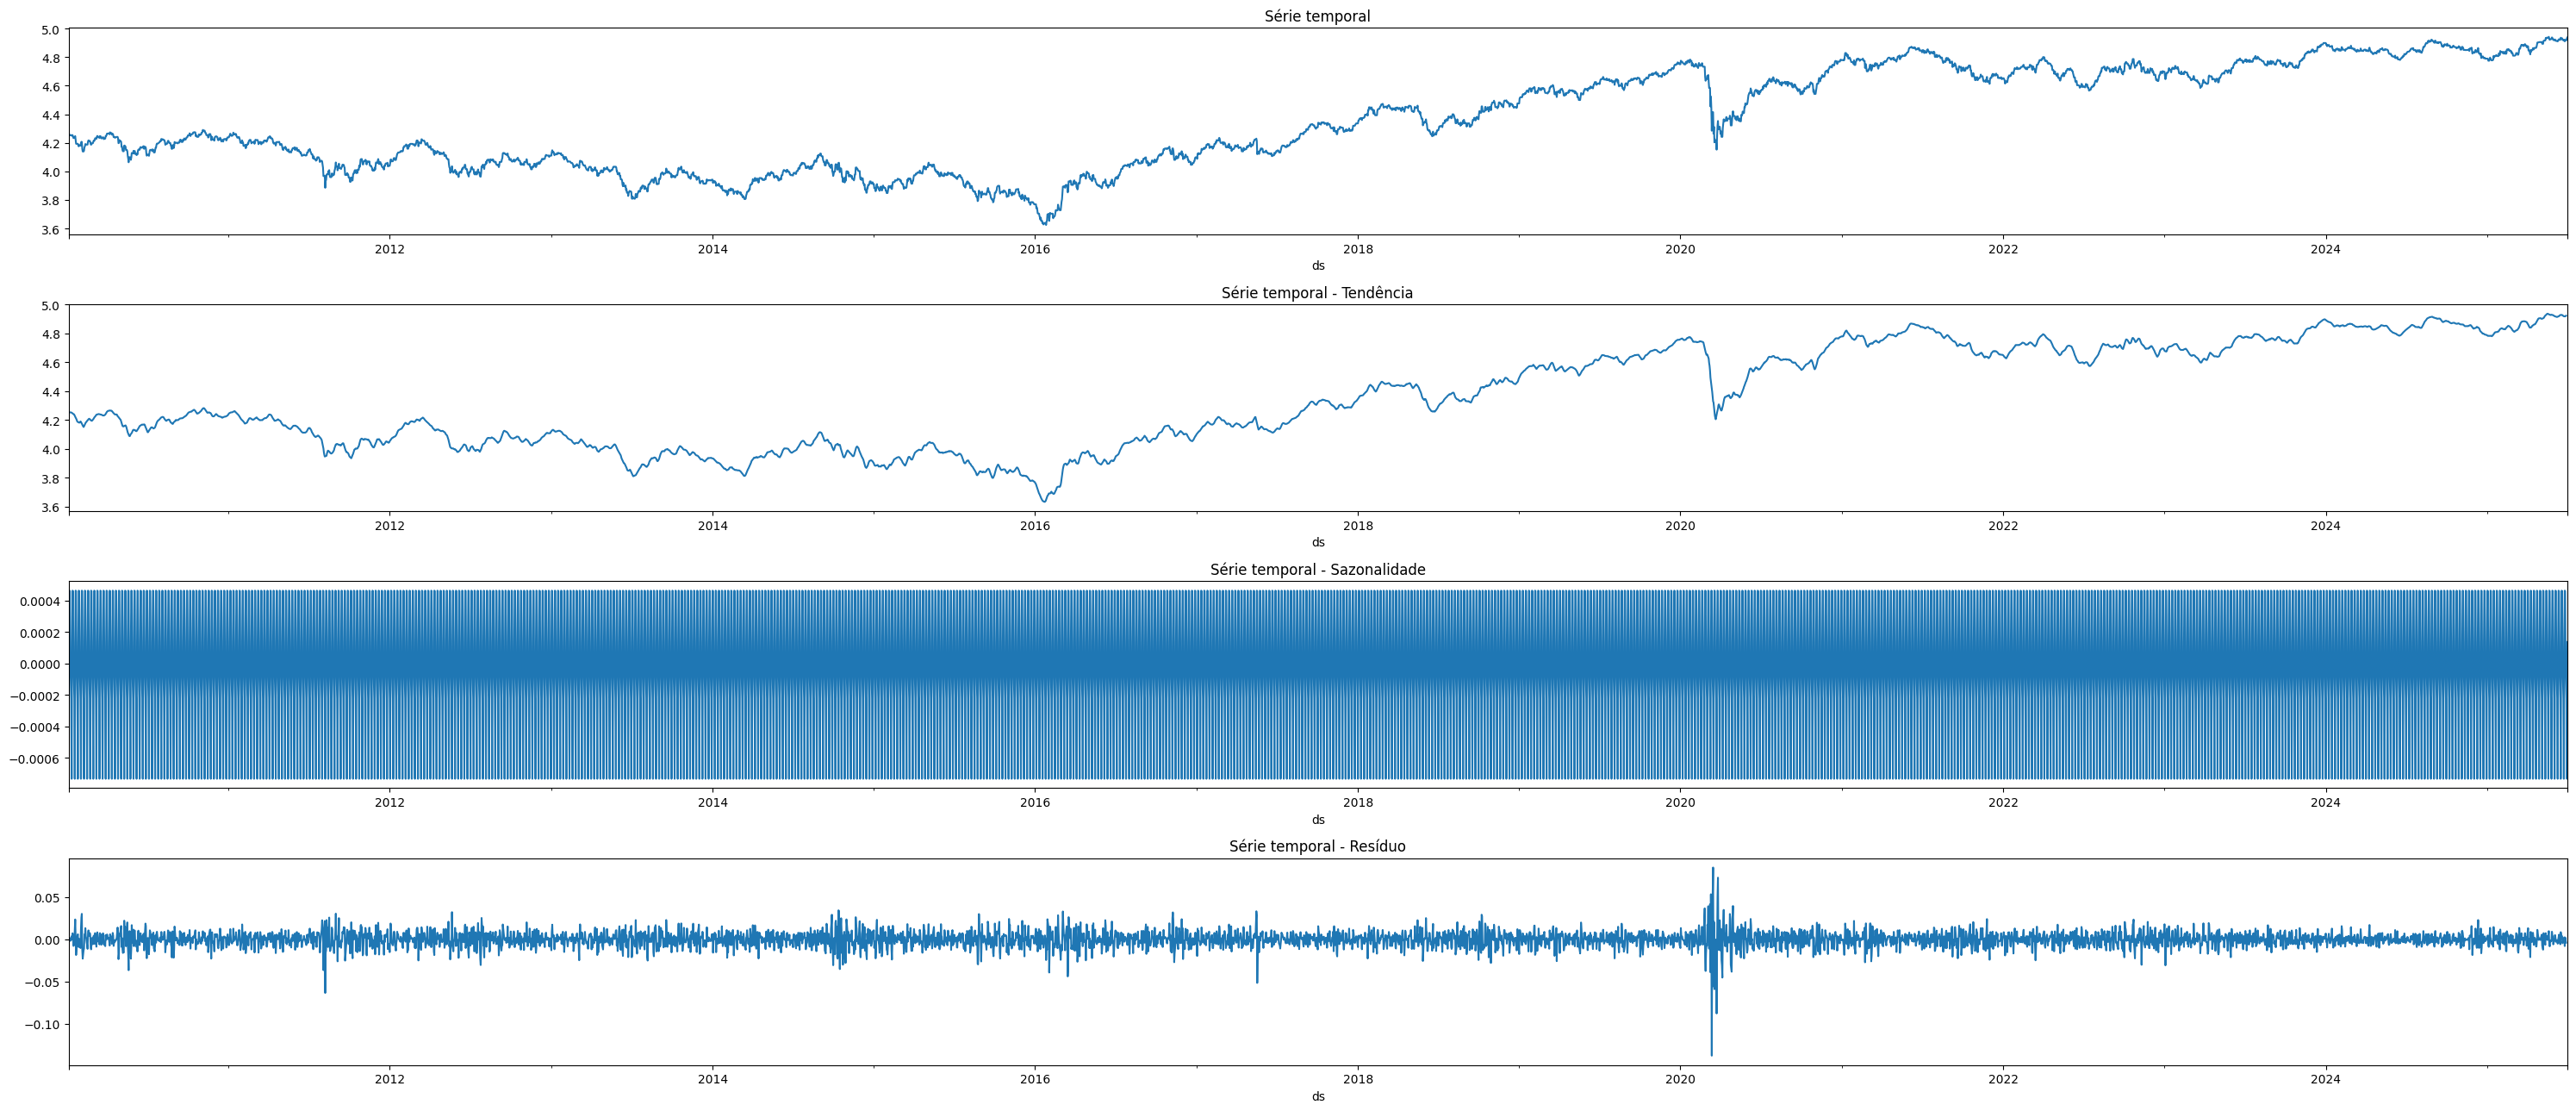

In [154]:
result = seasonal_decompose(df_log)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(30, 13))

result.observed.plot(ax=ax1)
result.trend.plot(ax=ax2)
result.seasonal.plot(ax=ax3)
result.resid.plot(ax=ax4)

ax1.set_title('Série temporal')
ax2.set_title('Série temporal - Tendência')
ax3.set_title('Série temporal - Sazonalidade')
ax4.set_title('Série temporal - Resíduo')

plt.tight_layout()

## Teste ADF série transformada em Log

In [155]:
result_adfuller = adfuller(df_log.y)

print('Teste A')

print(f'Teste estatístico: {result_adfuller[0]}')
print(f'P-value: {result_adfuller[1]}')
print('\n')

print('Valores críticos:')
for key,value in result_adfuller[4].items():
    print(f'{key}: {value}')

Teste A
Teste estatístico: -0.7968595270433892
P-value: 0.8200428176246295


Valores críticos:
1%: -3.431508950593034
5%: -2.862052143720248
10%: -2.5670426125081494


Portanto, aplicando a transformada logarítmica não ocorreram mudanças significativas na série temporal.

# Diferença entre série temporal logarítmica e média móvel

In [156]:
df_s = (df_log - ma_log).dropna()
ma_s = df_s.rolling(12).mean()
std_s = df_log.rolling(12).std()

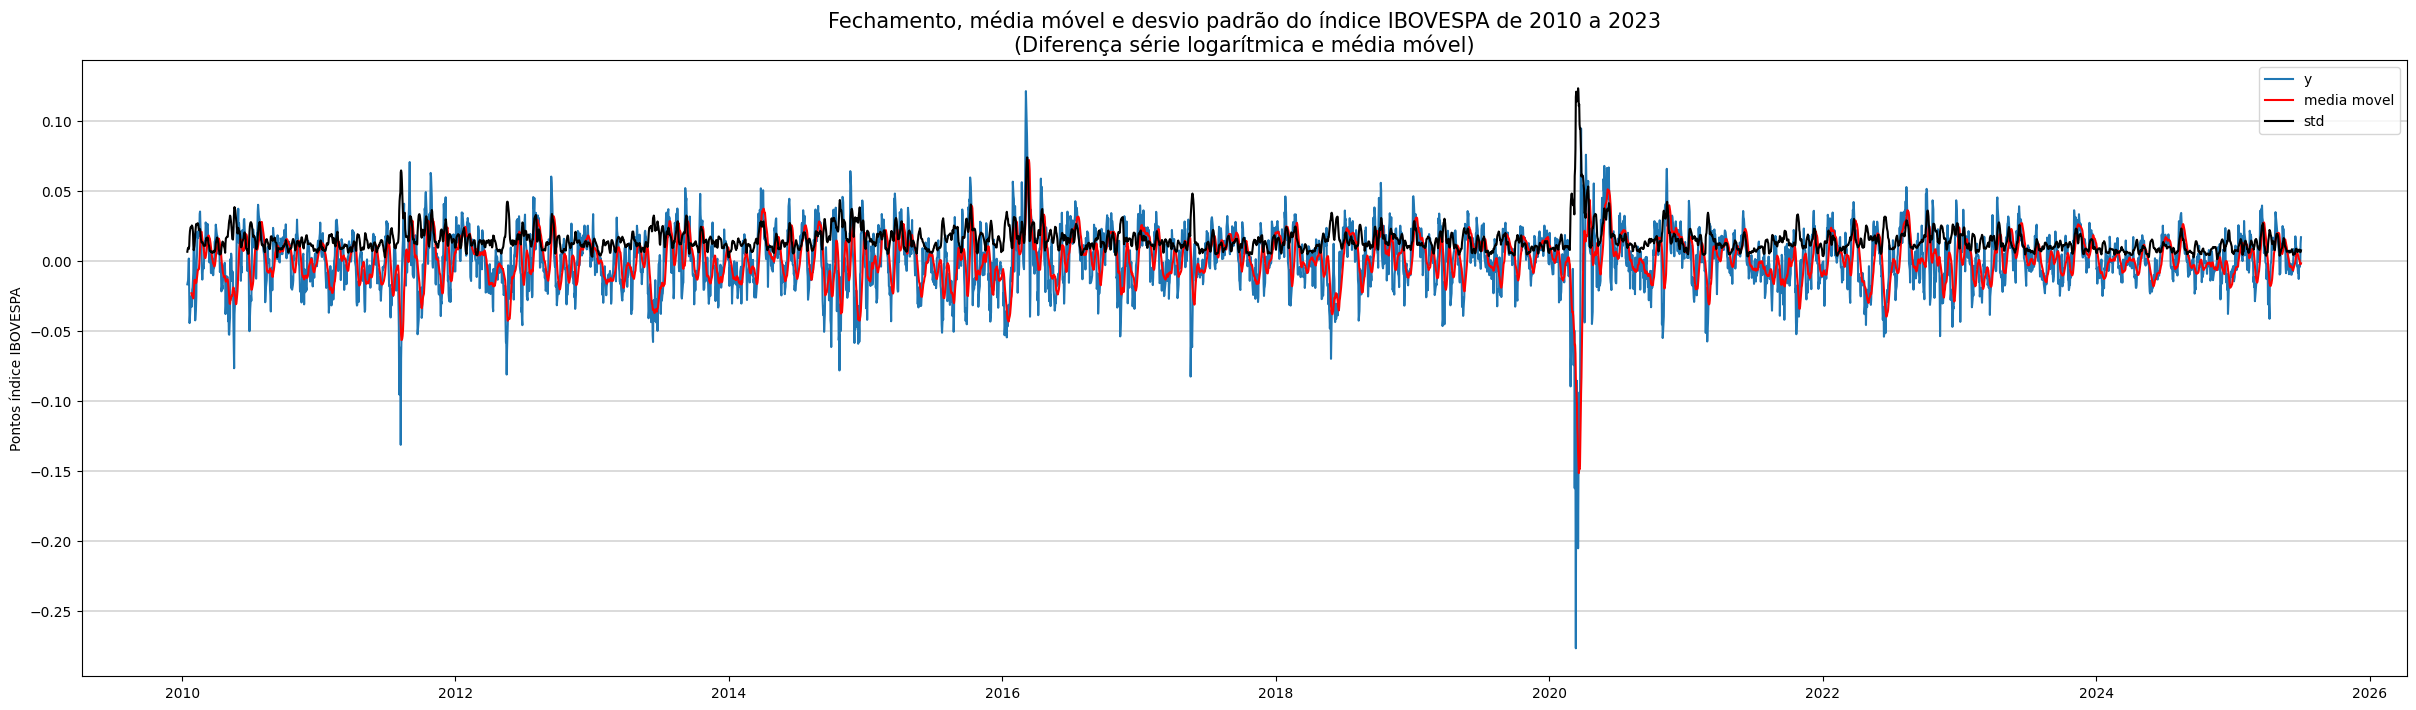

In [157]:
fig, ax = plt.subplots(figsize=(30,8))

sns.lineplot(df_s, x='ds', y='y', ax=ax, label='y')
sns.lineplot(ma_s, x='ds', y='y', ax=ax, color='r', label='media movel')
sns.lineplot(std_s, x='ds', y='y', ax=ax, color='black', label='std')

ax.grid(True, color='black', linewidth=0.2, axis='y')

ax.legend()

ax.set_title('Fechamento, média móvel e desvio padrão do índice IBOVESPA de 2010 a 2023\n(Diferença série logarítmica e média móvel)', fontsize=15)
ax.set_xlabel('')
ax.set_ylabel('Pontos índice IBOVESPA')

plt.show()

## Componentes da série

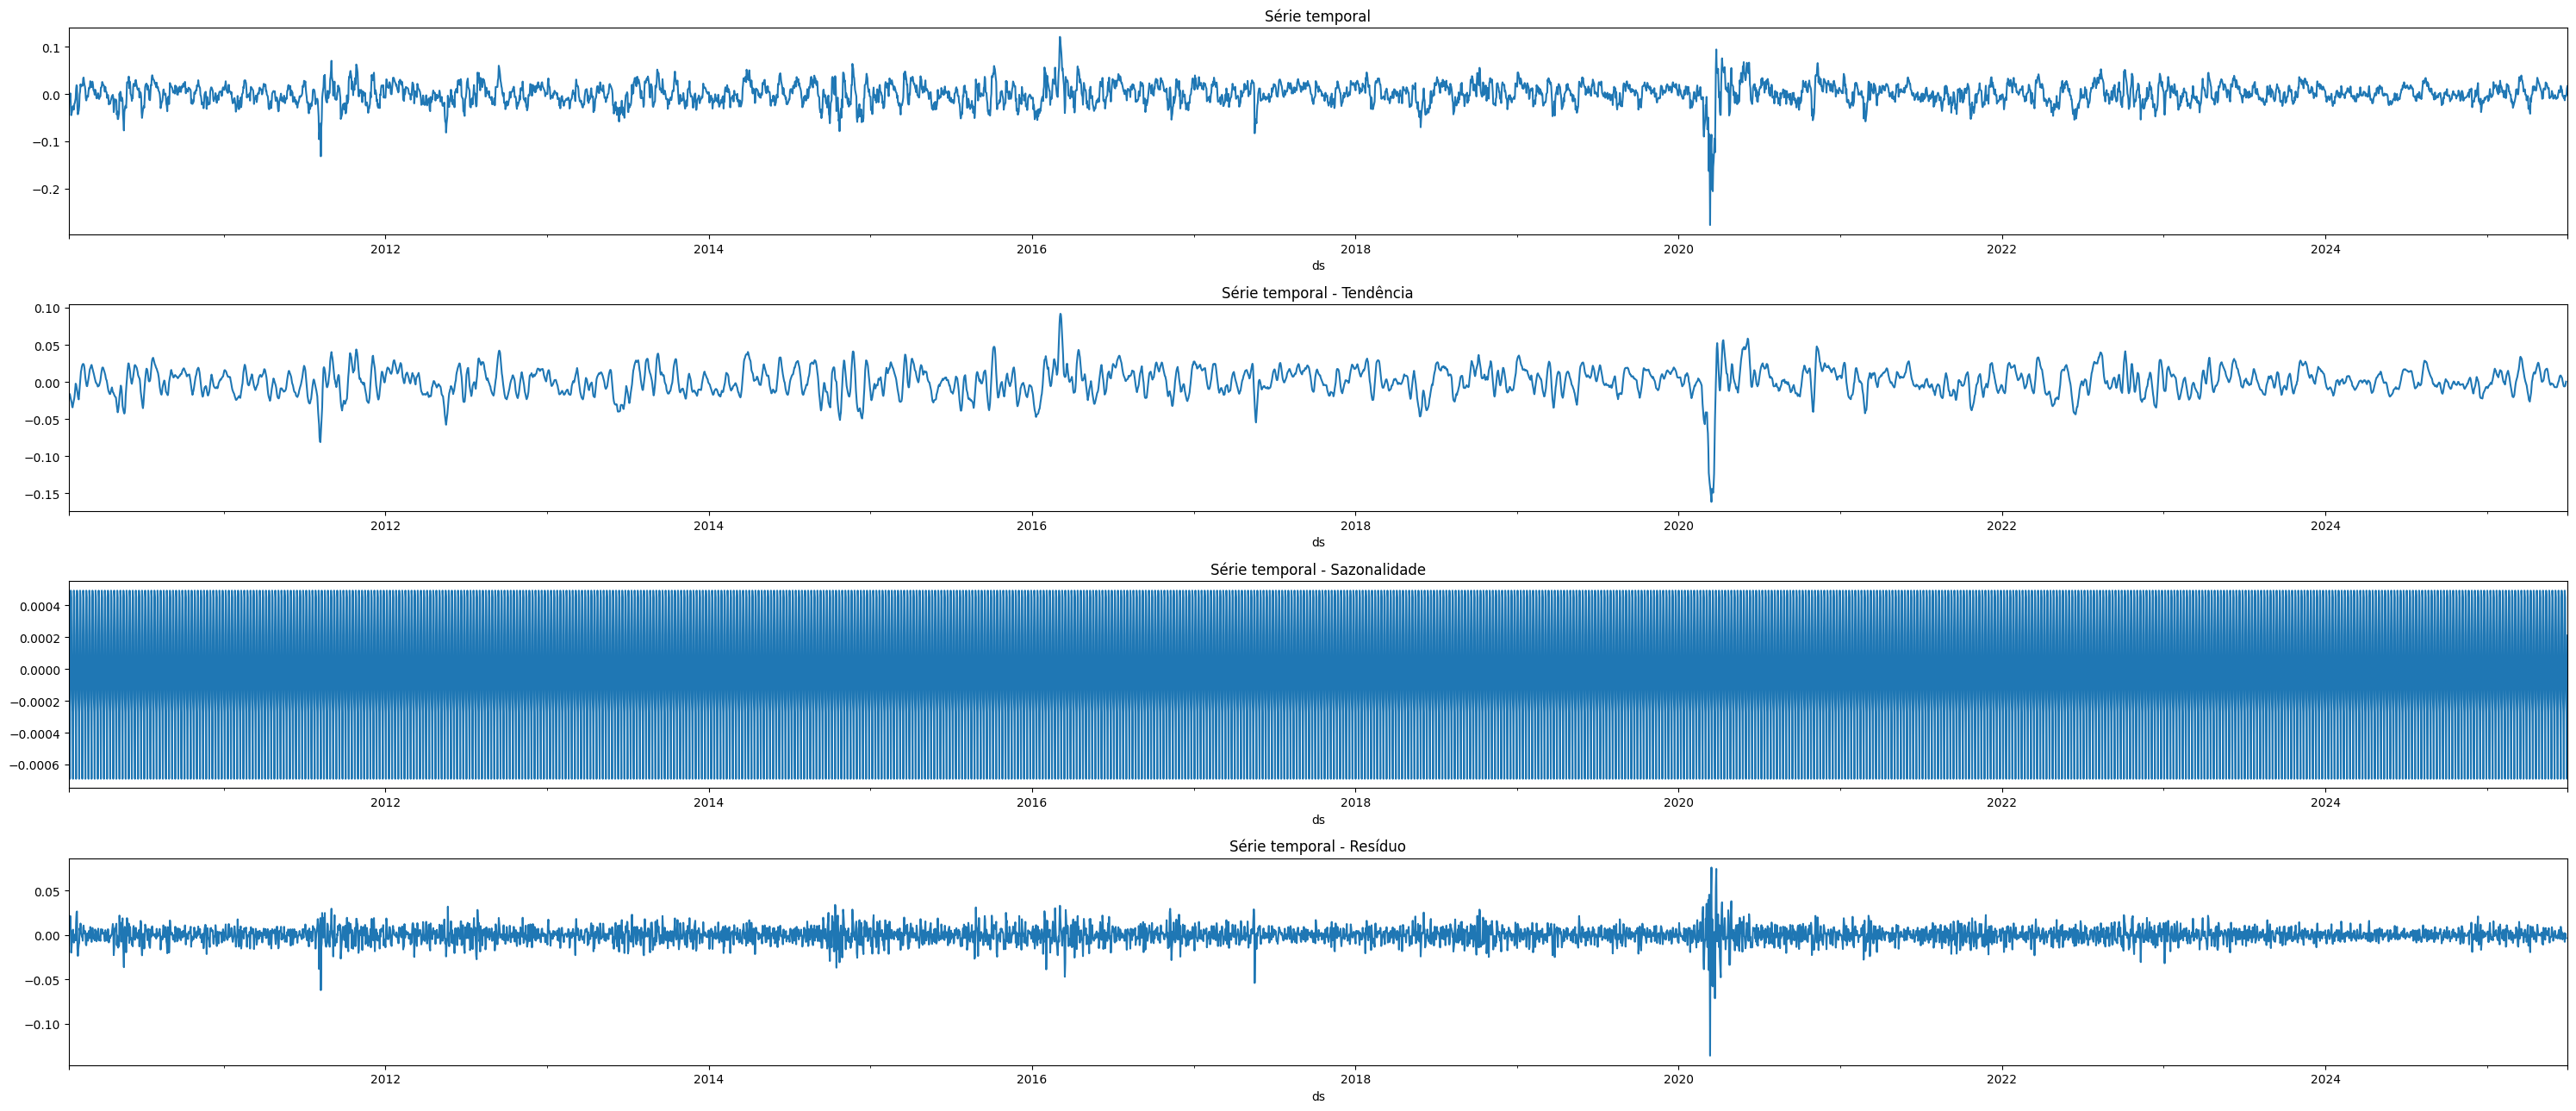

In [158]:
result = seasonal_decompose(df_s)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(30, 13))

result.observed.plot(ax=ax1)
result.trend.plot(ax=ax2)
result.seasonal.plot(ax=ax3)
result.resid.plot(ax=ax4)

ax1.set_title('Série temporal')
ax2.set_title('Série temporal - Tendência')
ax3.set_title('Série temporal - Sazonalidade')
ax4.set_title('Série temporal - Resíduo')

plt.tight_layout()

## Teste ADF

In [159]:
result_adfuller = adfuller(df_s.y)

print('Teste ADF')

print(f'Teste estatístico: {result_adfuller[0]}')
print(f'P-value: {result_adfuller[1]}')
print('\n')

print('Valores críticos:')
for key,value in result_adfuller[4].items():
    print(f'{key}: {value}')

if(result_adfuller[1] < result_adfuller[4]['5%']):
    print('H0 nula confirmada, não é estacionária')
else:
    print('H1 alternativa confirmada, é estacionária')

Teste ADF
Teste estatístico: -15.75413564066406
P-value: 1.2133545317392304e-28


Valores críticos:
1%: -3.4315112143970854
5%: -2.8620531439066594
10%: -2.567043144937886
H1 alternativa confirmada, é estacionária


Desta vez, a diferença entre a série em escala logarítmica e a média móvel resultou em uma série temporal mais constante, visualmente com caráter estacionário.

Tal hipótese foi confirmada com o teste A que indicou uma série temporal estacionária.

# Série temporal derivada

## Média móvel

In [160]:
df_diff = df_s.diff(1).dropna()
ma_diff = df_diff.rolling(12).mean()
std_diff = df_diff.rolling(12).std()
df_diff

y
ds                  
2010-01-16  0.001279
2010-01-17  0.001511
2010-01-18  0.007693
2010-01-19  0.007937
2010-01-20 -0.022266
...              ...
2025-06-27 -0.001599
2025-06-28  0.001443
2025-06-29  0.001193
2025-06-30  0.014345
2025-07-01  0.004487

[5646 rows x 1 columns]

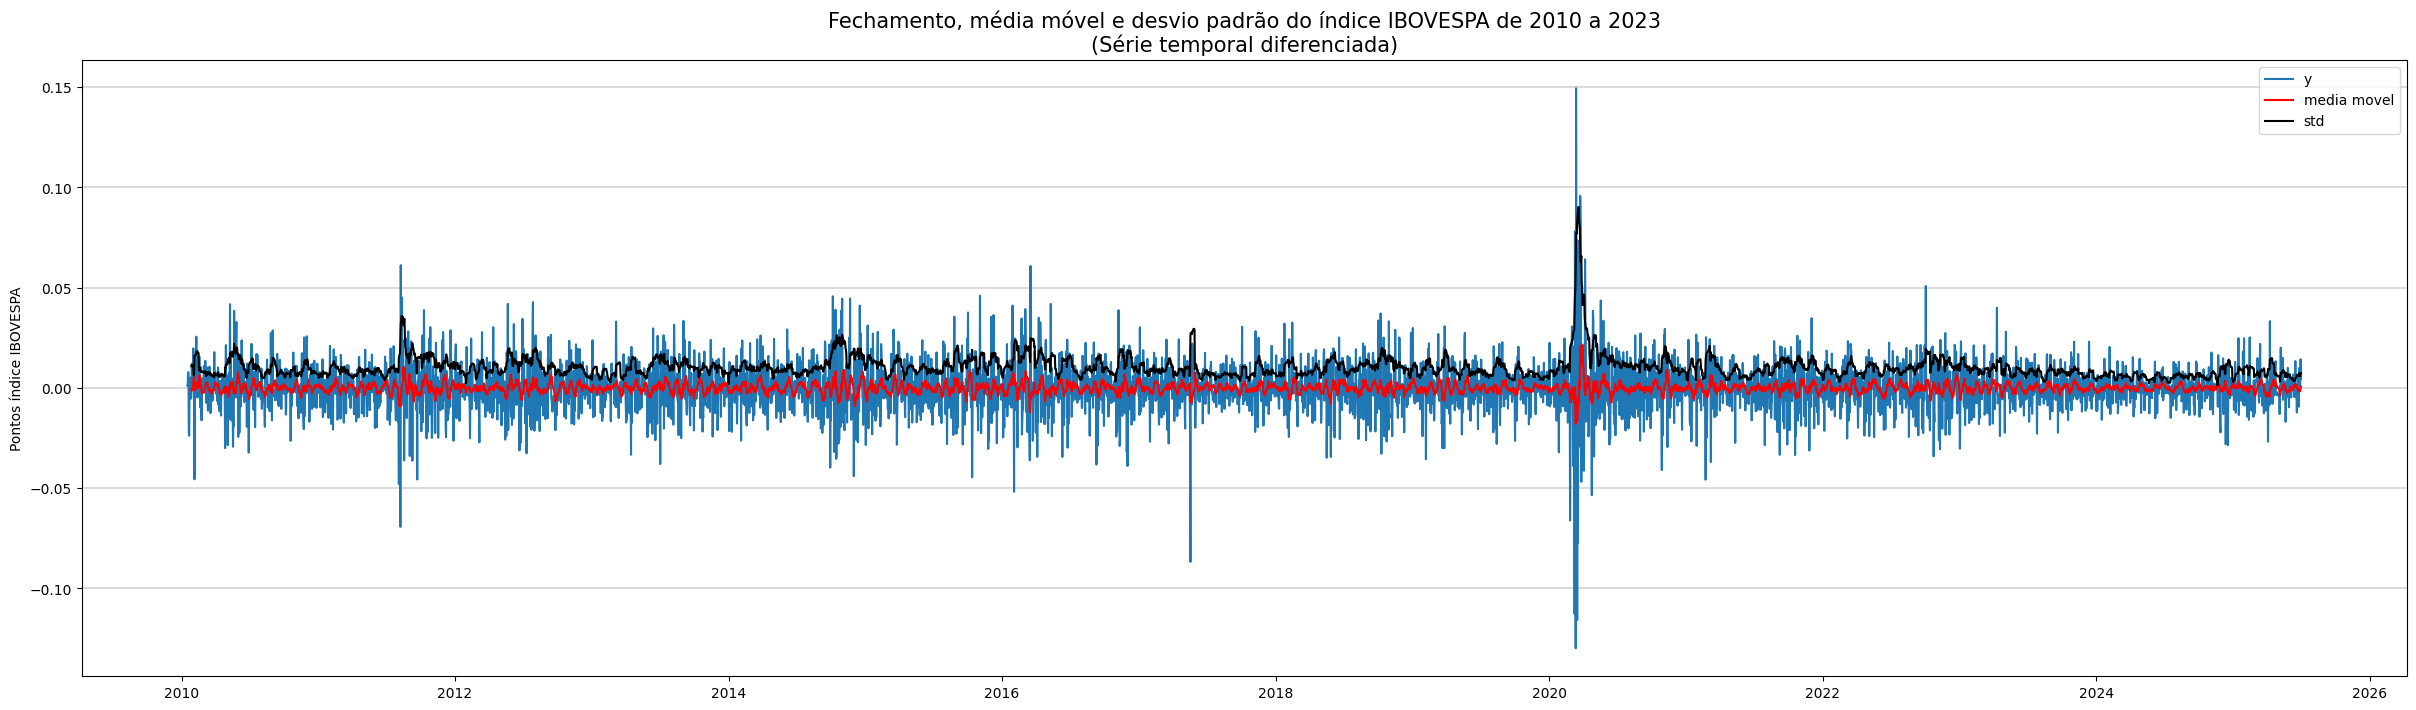

In [161]:
fig, ax = plt.subplots(figsize=(30,8))

sns.lineplot(df_diff, x='ds', y='y', ax=ax, label='y')
sns.lineplot(ma_diff, x='ds', y='y', ax=ax, color='r', label='media movel')
sns.lineplot(std_diff, x='ds', y='y', ax=ax, color='black', label='std')

ax.grid(True, color='black', linewidth=0.2, axis='y')

ax.legend()

ax.set_title('Fechamento, média móvel e desvio padrão do índice IBOVESPA de 2010 a 2023\n(Série temporal diferenciada)', fontsize=15)
ax.set_xlabel('')
ax.set_ylabel('Pontos índice IBOVESPA')

plt.show()

## Componentes da série

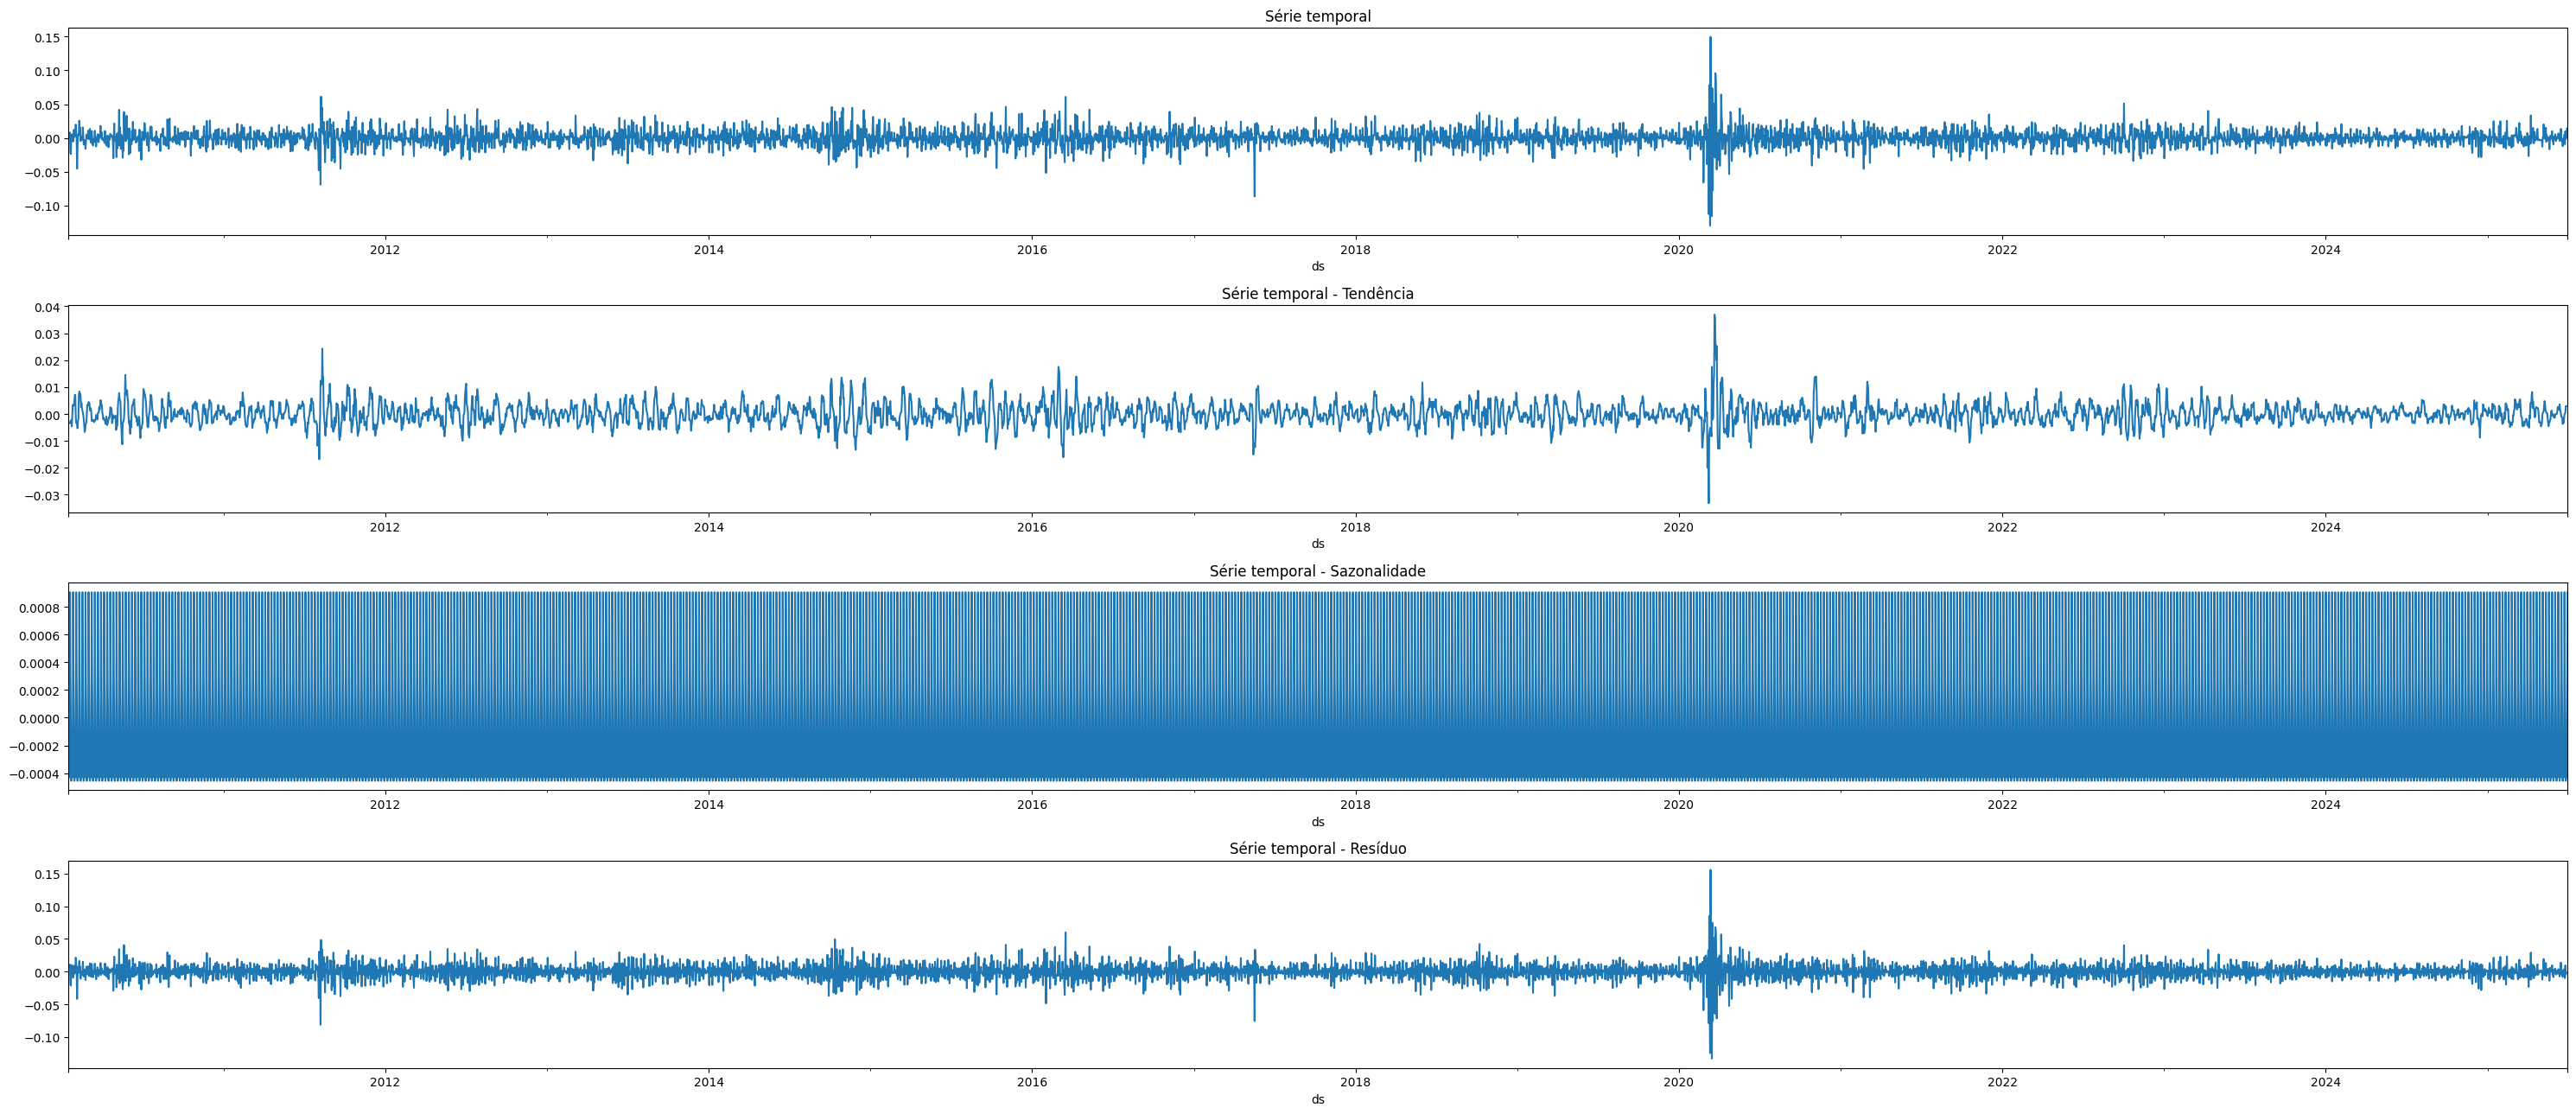

In [162]:
result = seasonal_decompose(df_diff)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(30, 13))

result.observed.plot(ax=ax1)
result.trend.plot(ax=ax2)
result.seasonal.plot(ax=ax3)
result.resid.plot(ax=ax4)

ax1.set_title('Série temporal')
ax2.set_title('Série temporal - Tendência')
ax3.set_title('Série temporal - Sazonalidade')
ax4.set_title('Série temporal - Resíduo')

plt.tight_layout()

## Teste ADF

In [163]:
result_adfuller = adfuller(df_diff.y)

print('Teste ADF')

print(f'Teste estatístico: {result_adfuller[0]}')
print(f'P-value: {result_adfuller[1]}')
print('\n')

print('Valores críticos:')
for key,value in result_adfuller[4].items():
    print(f'{key}: {value}')

if(result_adfuller[1] < result_adfuller[4]['5%']):
    print('H0 nula confirmada, não é estacionária')
else:
    print('H1 alternativa confirmada, é estacionária')

Teste ADF
Teste estatístico: -20.64649500412967
P-value: 0.0


Valores críticos:
1%: -3.4315155608549532
5%: -2.8620550642421536
10%: -2.567044167191412
H1 alternativa confirmada, é estacionária


Novamente, tem-se uma série temporal visualmente muito mais constante, com aspecto estacionário.

O teste ADF confirmar a hipótese de série temporal estacionária.

# ACF e PACF

Com as séries temporais estacionárias obtidas a partir da diferenciação da série original, podem ser calculados os valores de ACF (Autocorrelation Function) e PACF (Partial Autocorrelation Function).

Esta análise traz importantes resultados sobre a sazonalidade e a randomicidade da série temporal, bem como indica o grau de correlação entre os próprios intervalos de tempo existentes na série temporal.

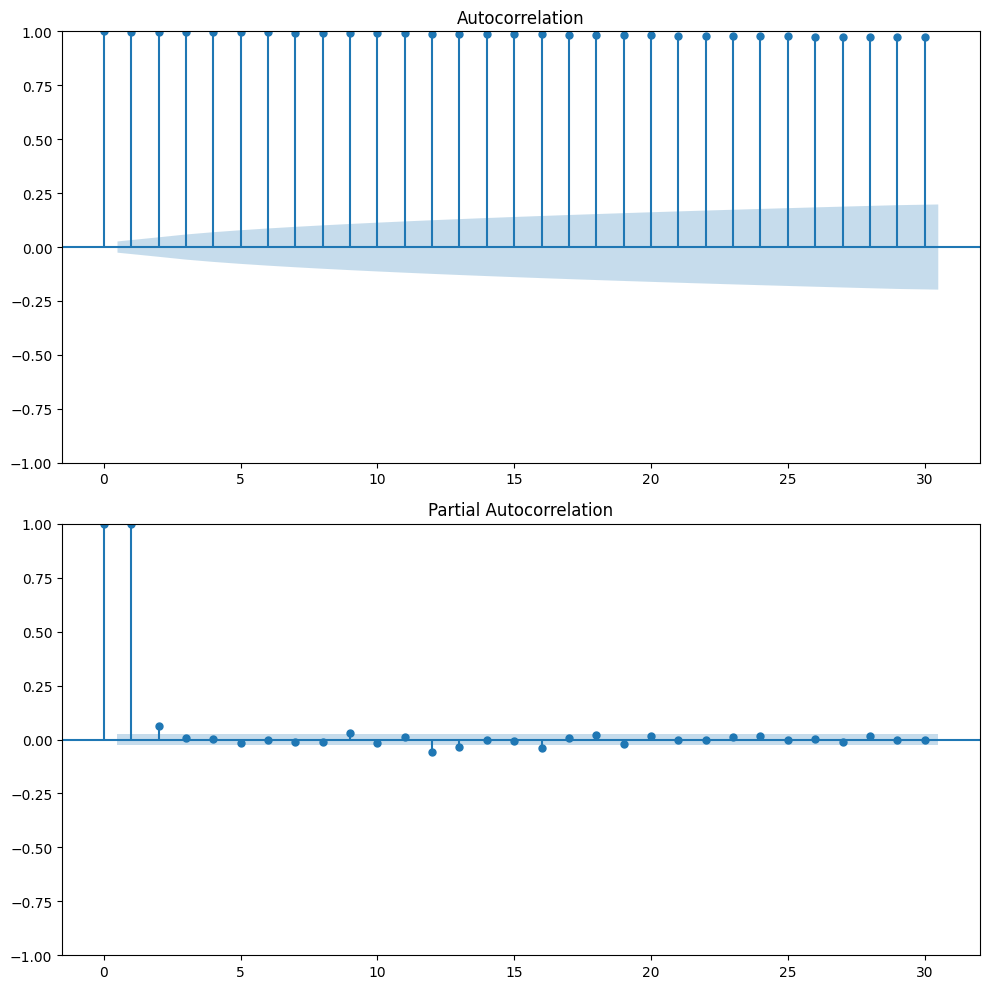

In [164]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,10))

plot_acf(df_date_index.y, lags=30, ax=ax[0])
plot_pacf(df_date_index.y, lags=30, ax=ax[1], method='ols')

plt.tight_layout()
plt.show()

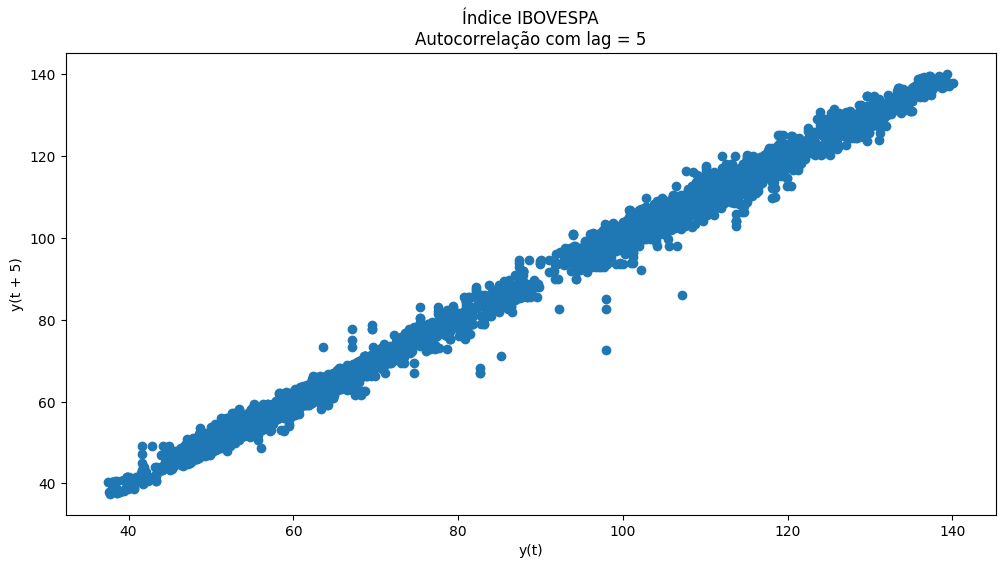

In [165]:
plt.figure(figsize=(12, 6))

lag_plot(df_date_index.y, lag=5)

plt.title('Índice IBOVESPA\nAutocorrelação com lag = 5')

plt.show()

Com os gráficos, confirma-se a existência de autocorrelação na série temporal, especialmente com lags pequenos, ou seja, em um intervalo de dias reduzido.

É perceptível uma forte autocorrelação na série temporal do IBOVESPA em intervalos de 5 dias (lag = 5), ou seja, analisando um período de 5 dias geralmente serão observados valores do índice muito semelhantes.

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

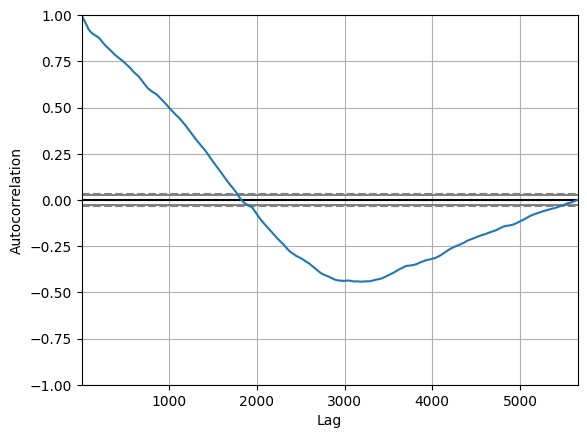

In [166]:
autocorrelation_plot(df_date_index)

# Datasets de treino e teste

In [169]:
train_set_date_col = df_date_col.loc[df_date_col.ds < '2025-01-01']
test_set_date_col = df_date_col.loc[(df_date_col.ds >= '2025-01-01') & (df_date_col.ds < '2025-06-01')]

train_set_date_index = df_date_index.loc[(df_date_index.index < '2025-06-01')]
test_set_date_index = df_date_index.loc[(df_date_index.index  >= '2025-01-01') & (df_date_index.index  < '2025-06-01')]


print(len(train_set_date_col))
print(len(test_set_date_col))

5476
151


# ARIMA

**Parâmetros:**
- p: The number of lag observations included in the model, also called the lag order.
- d: The number of times that the raw observations are differenced, also called the degree of differencing.
- q: The size of the moving average window, also called the order of moving average.

## Modelo ARIMA padrão

Será usado um lag de 5 dias no parãmetro p, tendo em vista que há forte autocorrelação nesse intervalo na série temporal.

In [173]:
arima_model = ARIMA(train_set_date_index, order=(5,1,0))

In [174]:
arima_model_fit = arima_model.fit()

In [175]:
y_pred = arima_model_fit.forecast(len(test_set_date_index))

In [176]:
residuals = pd.DataFrame(arima_model_fit.resid)

In [177]:
y_pred

2025-06-01    137.026564
2025-06-02    137.022016
2025-06-03    136.997288
2025-06-04    136.999462
2025-06-05    136.999495
                 ...    
2025-10-25    136.999075
2025-10-26    136.999075
2025-10-27    136.999075
2025-10-28    136.999075
2025-10-29    136.999075
Freq: D, Name: predicted_mean, Length: 151, dtype: float64

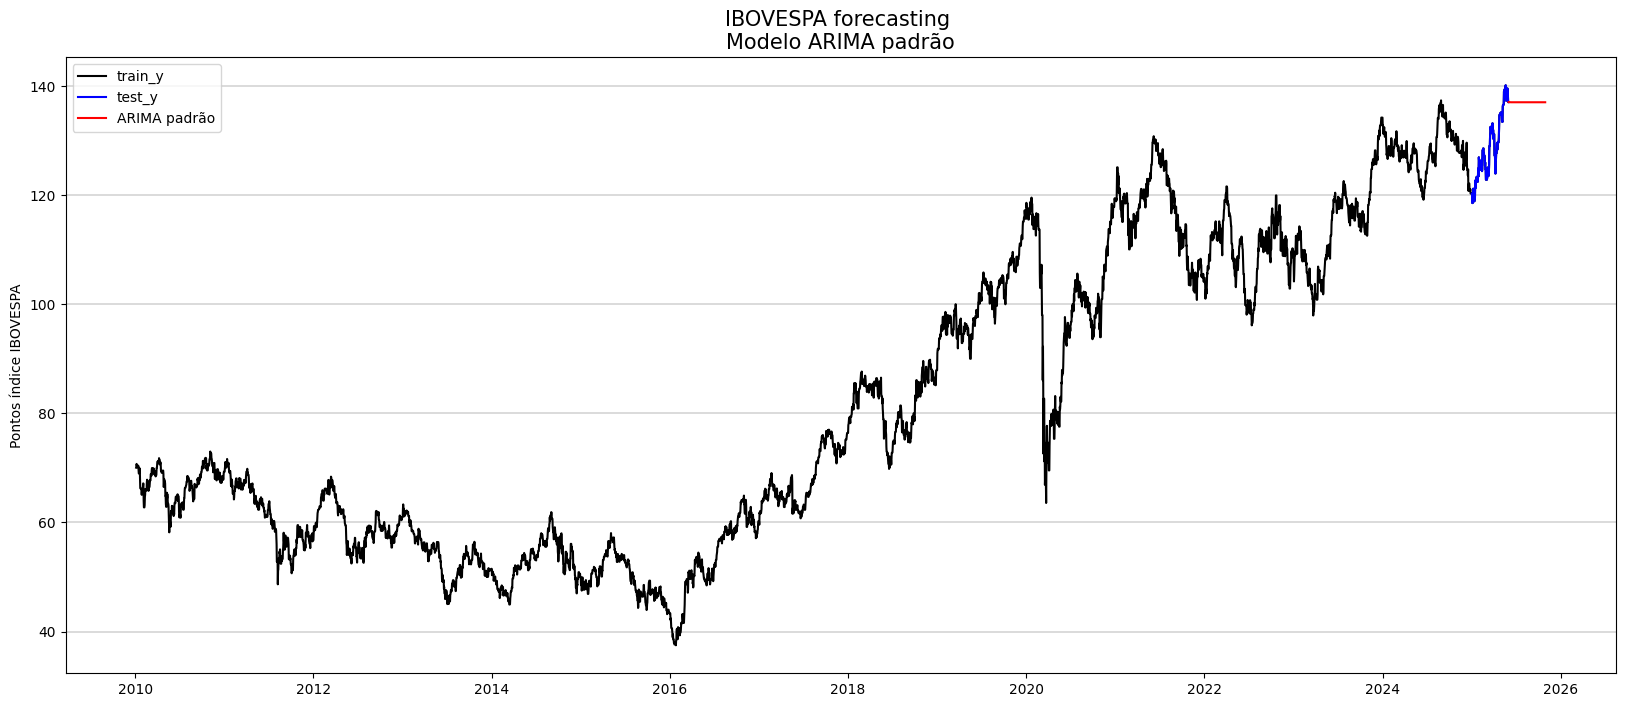

ARIMA padrão WMAPE: 6.75%
ARIMA padrão Test RMSE: 10.17
ARIMA padrão MAE: 8.68


In [178]:
model_ = 'ARIMA padrão'

fig, ax = plt.subplots(figsize=(20,8))

sns.lineplot(train_set_date_index, x='ds', y='y', ax=ax, label='train_y', color='black')
sns.lineplot(test_set_date_index, x='ds', y='y', ax=ax, color='blue', label='test_y')
sns.lineplot(y_pred, ax=ax, color='red', label='ARIMA padrão')

ax.grid(True, color='black', linewidth=0.2, axis='y')

ax.legend()

ax.set_title('IBOVESPA forecasting \nModelo ARIMA padrão', fontsize=15)
ax.set_xlabel('')
ax.set_ylabel('Pontos índice IBOVESPA')

plt.show()

wmape_ = calc_wmape(test_set_date_index.y.values, y_pred.values)
rmse_ = sqrt(mean_squared_error(test_set_date_index.y.values, y_pred.values))
mae_ = calc_mae(test_set_date_index.y.values, y_pred.values)

print(f'{model_} WMAPE: {wmape_:.2%}')
print(f'{model_} Test RMSE: %.2f' % rmse_)
print(f'{model_} MAE: %.2f' % mae_)

In [179]:
print(arima_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 5627
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -7814.224
Date:                sex, 18 jul 2025   AIC                          15640.449
Time:                        11:26:00   BIC                          15680.260
Sample:                    01-04-2010   HQIC                         15654.319
                         - 05-31-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0640      0.006    -10.738      0.000      -0.076      -0.052
ar.L2         -0.0071      0.006     -1.097      0.273      -0.020       0.006
ar.L3         -0.0007      0.007     -0.107      0.9

Apesar do valor baixo no WMAPE, analisando a curva é visível que o modelo não performou bem, pois foi prevista uma linha constante, muito distante do comportamento da série temporal que possui diversos altos e baixos.

Uma das hipóteses é que o modelo está utilizando o comportamente do dataset de treino para fazer todas as previsões do dataset de teste, quando, na verdade, a cada nova previsão o modelo deveria passar por um novo ajuste de acordo com o valor previsto.

## Modelo ARIMA "retroalimentado"

Para isso, será aplicada a lógica de um laço de repetiçao, em que a cada execução uma nova previsão é realizada e um novo ajuste é feito no modelo ARIMA.

Dessa forma, a cada nova previsão será usado um novo conjunto de treino para o modelo, dando mais dinamicidade à previsão da curva.

In [185]:
import warnings
warnings.filterwarnings("ignore")

In [186]:
y_pred_step = []
history = train_set_date_index.copy()

for i in range(len(test_set_date_index)):
    model_arima_retro = ARIMA(history, order=(5,1,0))
    model_arima_retro_fit = model_arima_retro.fit()

    output = model_arima_retro_fit.forecast(disp=0)
    yhat = output[0]
    y_pred_step.append(yhat)

    obs = test_set_date_index.values[i]

    history = pd.concat([history, pd.DataFrame({'y':obs}, index=[test_set_date_index.index[i]])])

    print('predicted=%f, expected=%f' % (yhat, obs))

y_pred = test_set_date_index.copy()
y_pred.y = y_pred_step

predicted=137.026564, expected=120.283000


KeyError: 0

TypeError: Data source must be a DataFrame or Mapping, not <class 'pandas.core.series.Series'>.

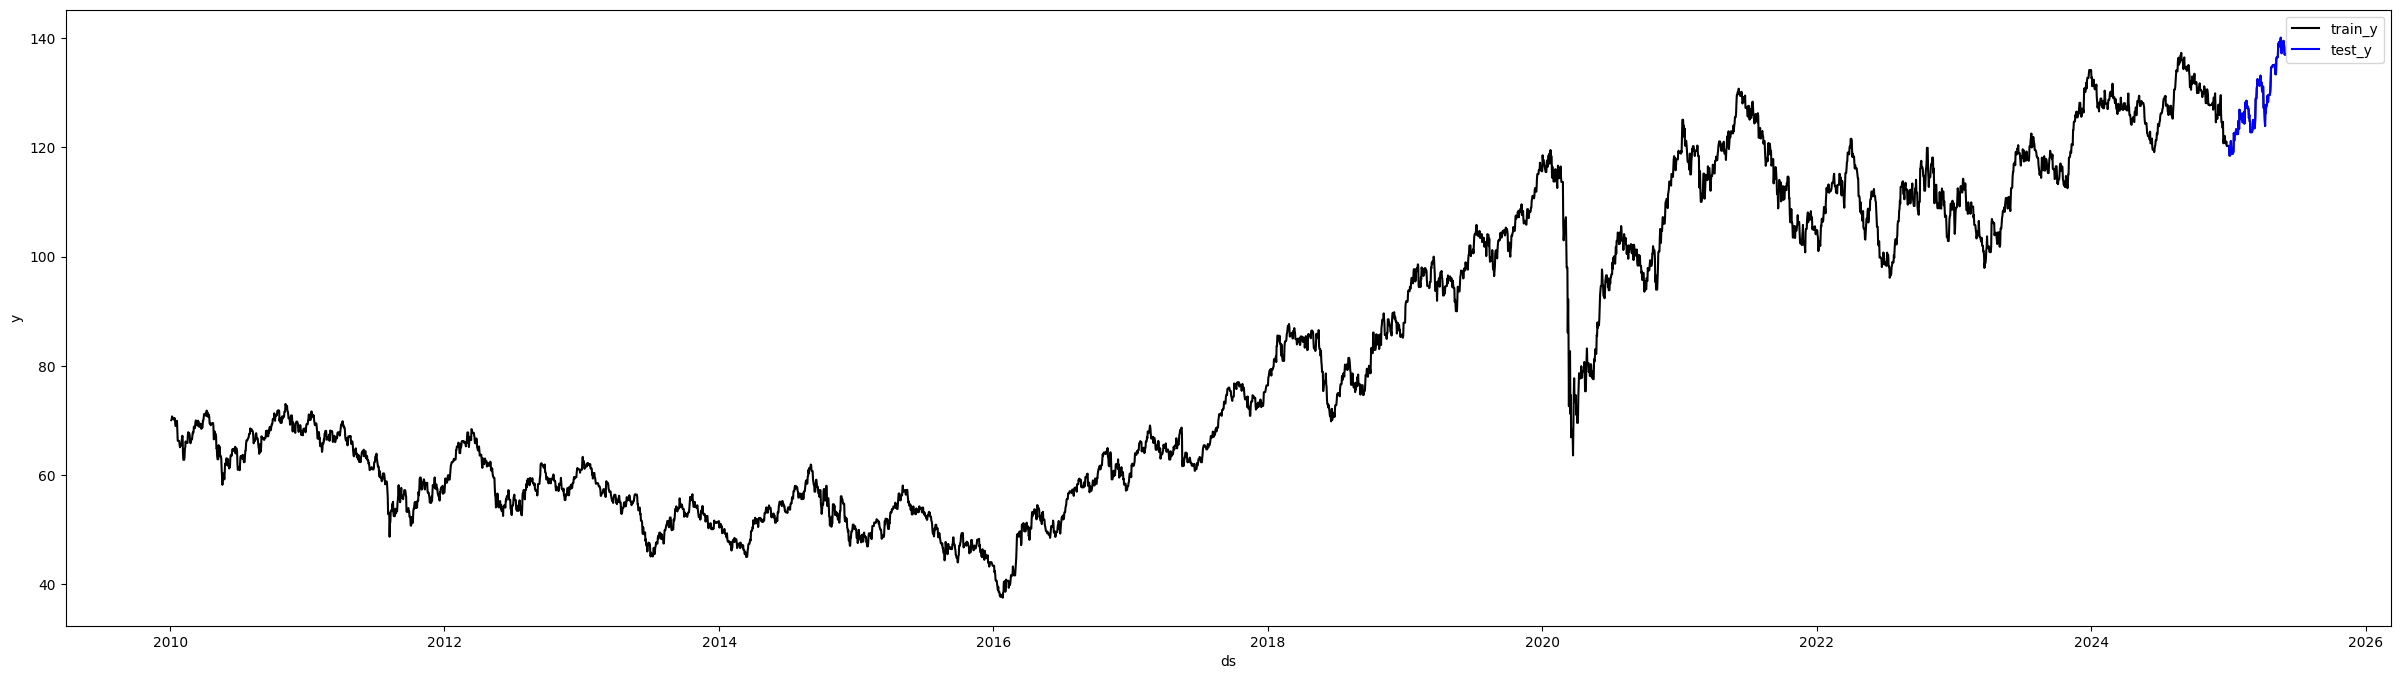

In [184]:
model_ = 'ARIMA dinâmico'

fig, ax = plt.subplots(figsize=(30,8))

sns.lineplot(train_set_date_index, x='ds', y='y', ax=ax, label='train_y', color='black')
sns.lineplot(test_set_date_index, x='ds', y='y', ax=ax, color='blue', label='test_y')
sns.lineplot(y_pred, x='ds', y='y', ax=ax, color='red', label=f'{model_}')

ax.grid(True, color='black', linewidth=0.2, axis='y')

ax.legend()

ax.set_title(f'IBOVESPA forecasting \nModelo {model_}', fontsize=15)
ax.set_xlabel('')
ax.set_ylabel('Pontos índice IBOVESPA')

plt.show()

wmape_ = calc_wmape(test_set_date_index.y.values, y_pred.y.values)
rmse_ = sqrt(mean_squared_error(test_set_date_index.y.values, y_pred.y.values))
mae_ = calc_mae(test_set_date_index.y.values, y_pred.y.values)

print(f'{model_} WMAPE: {wmape_:.2%}')
print(f'{model_} Test RMSE: %.2f' % rmse_)
print(f'{model_} MAE: %.2f' % mae_)

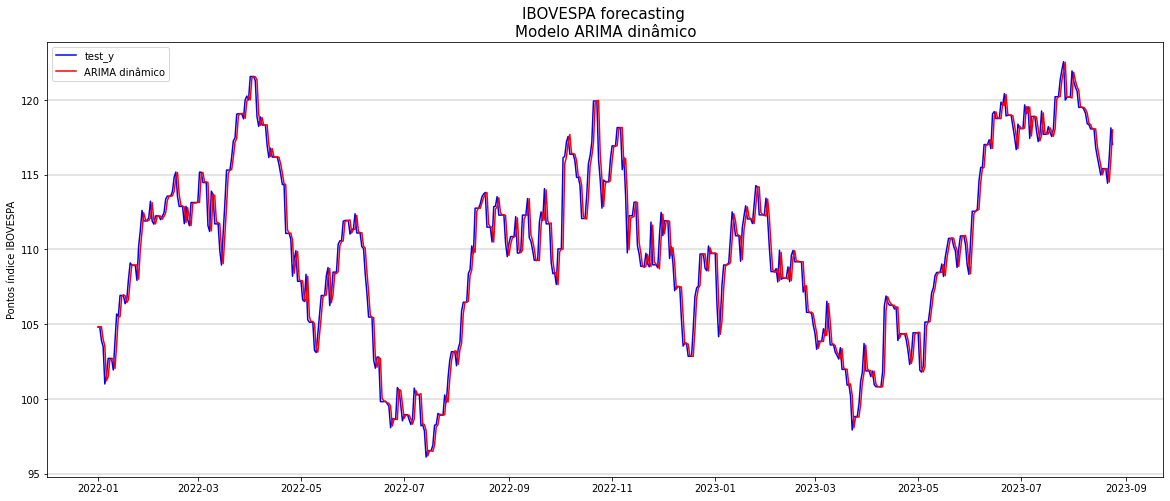

ARIMA dinâmico WMAPE: 0.70%
ARIMA dinâmico Test RMSE: 1.15
ARIMA dinâmico MAE: 0.77


In [ ]:
model_ = 'ARIMA dinâmico'

fig, ax = plt.subplots(figsize=(20,8))

sns.lineplot(test_set_date_index, x='ds', y='y', ax=ax, color='blue', label='test_y')
sns.lineplot(y_pred, x='ds', y='y', ax=ax, color='red', label=f'{model_}')

ax.grid(True, color='black', linewidth=0.2, axis='y')

ax.legend()

ax.set_title(f'IBOVESPA forecasting \nModelo {model_}', fontsize=15)
ax.set_xlabel('')
ax.set_ylabel('Pontos índice IBOVESPA')

plt.show()

wmape_ = calc_wmape(test_set_date_index.y.values, y_pred.y.values)
rmse_ = sqrt(mean_squared_error(test_set_date_index.y.values, y_pred.y.values))
mae_ = calc_mae(test_set_date_index.y.values, y_pred.y.values)

print(f'{model_} WMAPE: {wmape_:.2%}')
print(f'{model_} Test RMSE: %.2f' % rmse_)
print(f'{model_} MAE: %.2f' % mae_)

In [ ]:
model_arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4980
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -6932.338
Date:                Mon, 04 Sep 2023   AIC                          13876.676
Time:                        08:32:12   BIC                          13915.754
Sample:                    01-04-2010   HQIC                         13890.375
                         - 08-23-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0658      0.006    -10.726      0.000      -0.078      -0.054
ar.L2         -0.0039      0.007     -0.588      0.556      -0.017       0.009
ar.L3          0.0018      0.007      0.262      0.793      -0.012       0.016
ar.L4          0.0198      0.007      2.772      0.006       0.006       0.034
ar.L5         -0.0059      0.008     -0.741      0.459      -0.022       0.010
sigma2         0.9481      0.007    131.699      0.000       0.934       0.962
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             93863.58
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               4.42   Skew:                            -1.31
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""